In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr
import geopandas as gpd
import regionmask

import seaborn as sns

# Plotting options
sns.set(font_scale=1.3)
sns.set_style("whitegrid")

In [131]:
# open all the downloaded GLDAS files (one for each time-step) and combine them through time
gldas = xr.open_mfdataset('GLDAS files/*.nc4', 
                         concat_dim="time", combine="nested", data_vars='minimal', coords='minimal', compat='override')
gldas

<xarray.Dataset>
Dimensions:       (time: 264, bnds: 2, lon: 360, lat: 150)
Coordinates:
  * time          (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2021-12-01
  * lon           (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    Rainf_tavg    (time, lat, lon) float32 dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    Evap_tavg     (time, lat, lon) float32 dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    Rainf_f_tavg  (time, lat, lon) float32 dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    Tair_f_inst   (time, lat, lon) float32 dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
Attributes: (12/21)
    CDI:                       Climate Data Interface version 1.9.8 (https://...
    Conventions:               CF-1.6
    history:                   created on date: 2019-09-17T14:58:21.836
    source:                    Noah_v3.6 forced with GDAS-AGRMET-GPCPv13rA1
    institution:               NASA GSFC
    missing_value:             -9999.0
    ...                        ...
    SOUTH_WEST_CORNER_LON:     -179.875
    DX:                        0.25
    DY:                        0.25
    history_L34RS:             'Created by L34RS v1.4.2 @ NASA GES DISC on Ma...
    CDO:                       Climate Data Operators version 1.9.8 (https://...
    cdo_openmp_thread_number:  32

In [132]:
# import shapefile basins, select São Francisco
url =  ("/Users/mariafleury/Desktop/Senior Thesis/coding/water:geospatial/RegioesHidrograficasBrasil.zip")
basins = gpd.read_file(url)
sf_full = basins[basins.rhi_nm == "SÃO FRANCISCO"]

In [133]:
#import sub_basins
url =  ("/Users/mariafleury/Desktop/Senior Thesis/coding/water:geospatial/meso_RH.zip")
sub_basins = gpd.read_file(url)

# selecting SF sub-basins
sf_med = sub_basins[sub_basins.nm_mesoRH == "Médio São Francisco"]
sf_sub = sub_basins[sub_basins.nm_mesoRH == "Submédio São Francisco"]
sf_bai = sub_basins[sub_basins.nm_mesoRH == "Baixo São Francisco"]
sf_alt = sub_basins[sub_basins.nm_mesoRH == "Alto São Francisco"]

# create a new data frame with only the SF sub-basins
sf_all = sf_med.copy(deep=True)
sf_all = sf_all.append([sf_sub,sf_bai,sf_alt])

/var/folders/s9/3jg0s6mx1bb06h61dh7_v34c0000gn/T/ipykernel_19280/1613620207.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sf_all = sf_all.append([sf_sub,sf_bai,sf_alt])


In [134]:
# Create a 3d mask - this contains the true / false values identifying pixels
# inside vs outside of the mask region --> center point of pixel = reference point

# mask for the full SF basin
sf_mask = regionmask.mask_3D_geopandas(sf_full,
                                         gldas.lon,
                                         gldas.lat)

# mask for the sub-regions
sf_bai_mask = regionmask.mask_3D_geopandas(sf_bai,
                                         gldas.lon,
                                         gldas.lat)
                                    
sf_sub_mask = regionmask.mask_3D_geopandas(sf_sub,
                                         gldas.lon,
                                         gldas.lat)

sf_med_mask = regionmask.mask_3D_geopandas(sf_med,
                                         gldas.lon,
                                         gldas.lat)
sf_alt_mask = regionmask.mask_3D_geopandas(sf_alt,
                                         gldas.lon,
                                         gldas.lat)

In [135]:
# define rectangular bounds of watershed
aoi_lat = [float(sf_full.total_bounds[1]), float(sf_full.total_bounds[3])]
aoi_lon = [float(sf_full.total_bounds[0]), float(sf_full.total_bounds[2])]

### Rainfall

In [136]:
# Use bounds and 3D mask of São Francisco River basin to select relevant rainfall data pixels
rain_masked = gldas["Rainf_tavg"].sel(lon=slice(aoi_lon[0],
                                                                              aoi_lon[1]),
                                                                    lat=slice(aoi_lat[0],
                                                                              aoi_lat[1])).where(sf_mask)

# Same for sub-basins
rain_bai_masked = gldas["Rainf_tavg"].sel(lon=slice(aoi_lon[0],
                                                                              aoi_lon[1]),
                                                                    lat=slice(aoi_lat[0],
                                                                              aoi_lat[1])).where(sf_bai_mask)
rain_sub_masked = gldas["Rainf_tavg"].sel(lon=slice(aoi_lon[0],
                                                                              aoi_lon[1]),
                                                                    lat=slice(aoi_lat[0],
                                                                              aoi_lat[1])).where(sf_sub_mask)
rain_med_masked = gldas["Rainf_tavg"].sel(lon=slice(aoi_lon[0],
                                                                              aoi_lon[1]),
                                                                    lat=slice(aoi_lat[0],
                                                                              aoi_lat[1])).where(sf_med_mask)
rain_alt_masked = gldas["Rainf_tavg"].sel(lon=slice(aoi_lon[0],
                                                                              aoi_lon[1]),
                                                                    lat=slice(aoi_lat[0],
                                                                              aoi_lat[1])).where(sf_alt_mask)

In [137]:
# create spatial mean of raifnall data using xarray function
# change xarray to dataframe
rain_mean = rain_masked.mean(["lat", "lon"])
rain_mean = rain_mean.to_dataframe()
rain_mean.reset_index(inplace=True)

# 1kg/m2/s = 86400mm/day
conv = 86400
rain_mean['rain'] = rain_mean.Rainf_tavg *conv

y=-0.001873x+(2.771199)


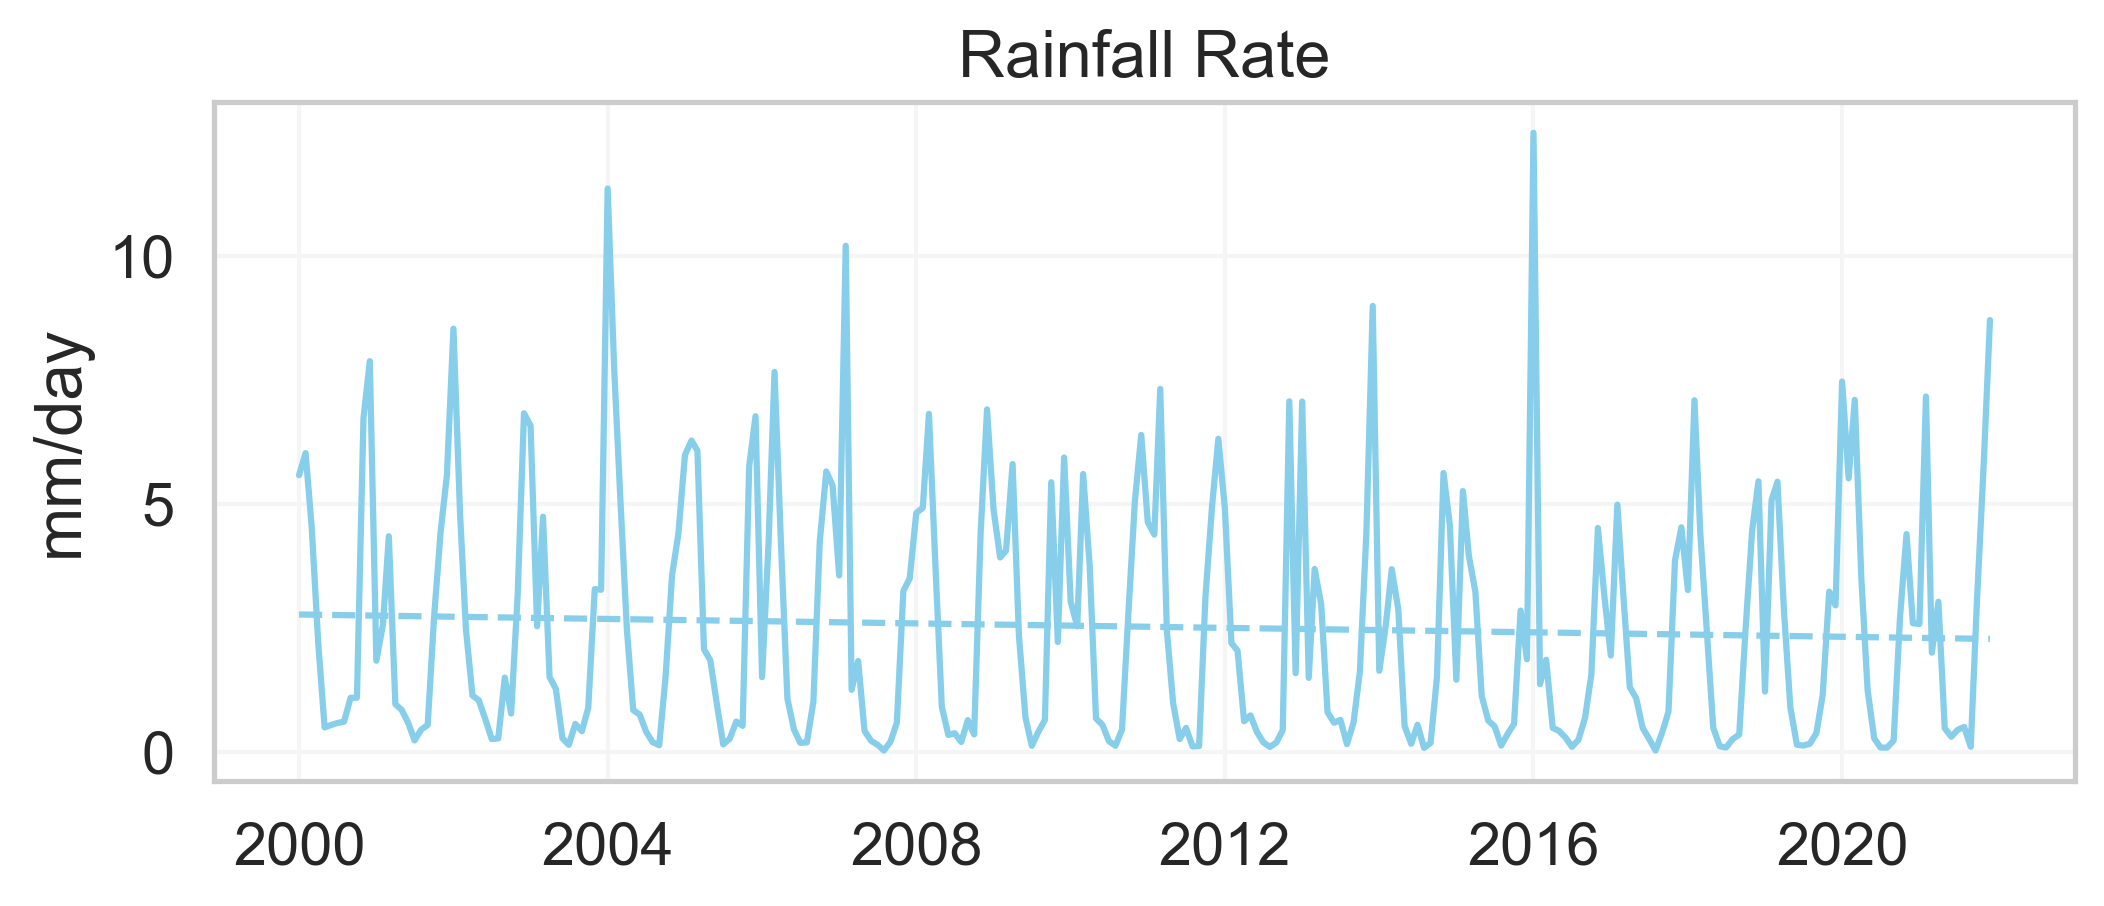

In [138]:
# Plot rainfall rate over the basin
f, ax = plt.subplots(figsize=[8,3],dpi=300)


plt.grid('both', color='whitesmoke')
ax.plot(rain_mean.time,rain_mean.rain, color="skyblue")


# trendline (linear fitting)
z = np.polyfit(rain_mean.index, rain_mean.rain, 1)
p = np.poly1d(z)
ax.plot(rain_mean.time,p(rain_mean.index),'--',color="skyblue")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

plt.title('Rainfall Rate')
plt.ylabel('mm/day')
plt.show()

# saves figure in same directory as the code file
f.savefig('sf_full_rainfall.png',bbox_inches='tight')

In [139]:
# create spatial mean of rainfall data using xarray function for sub-basisns
# change xarray to dataframe

# 1kg/m2/s = 86400mm/day
conv = 86400

rain_bai_mean = rain_bai_masked.mean(["lat", "lon"])
rain_bai_mean = rain_bai_mean.to_dataframe()
rain_bai_mean.reset_index(inplace=True)
rain_bai_mean['rain'] = rain_bai_mean.Rainf_tavg *conv

rain_sub_mean = rain_sub_masked.mean(["lat", "lon"])
rain_sub_mean = rain_sub_mean.to_dataframe()
rain_sub_mean.reset_index(inplace=True)
rain_sub_mean['rain'] = rain_sub_mean.Rainf_tavg *conv

rain_med_mean = rain_med_masked.mean(["lat", "lon"])
rain_med_mean = rain_med_mean.to_dataframe()
rain_med_mean.reset_index(inplace=True)
rain_med_mean['rain'] = rain_med_mean.Rainf_tavg *conv

rain_alt_mean = rain_alt_masked.mean(["lat", "lon"])
rain_alt_mean = rain_alt_mean.to_dataframe()
rain_alt_mean.reset_index(inplace=True)
rain_alt_mean['rain'] = rain_alt_mean.Rainf_tavg *conv


y=-0.004025x+(2.226997)


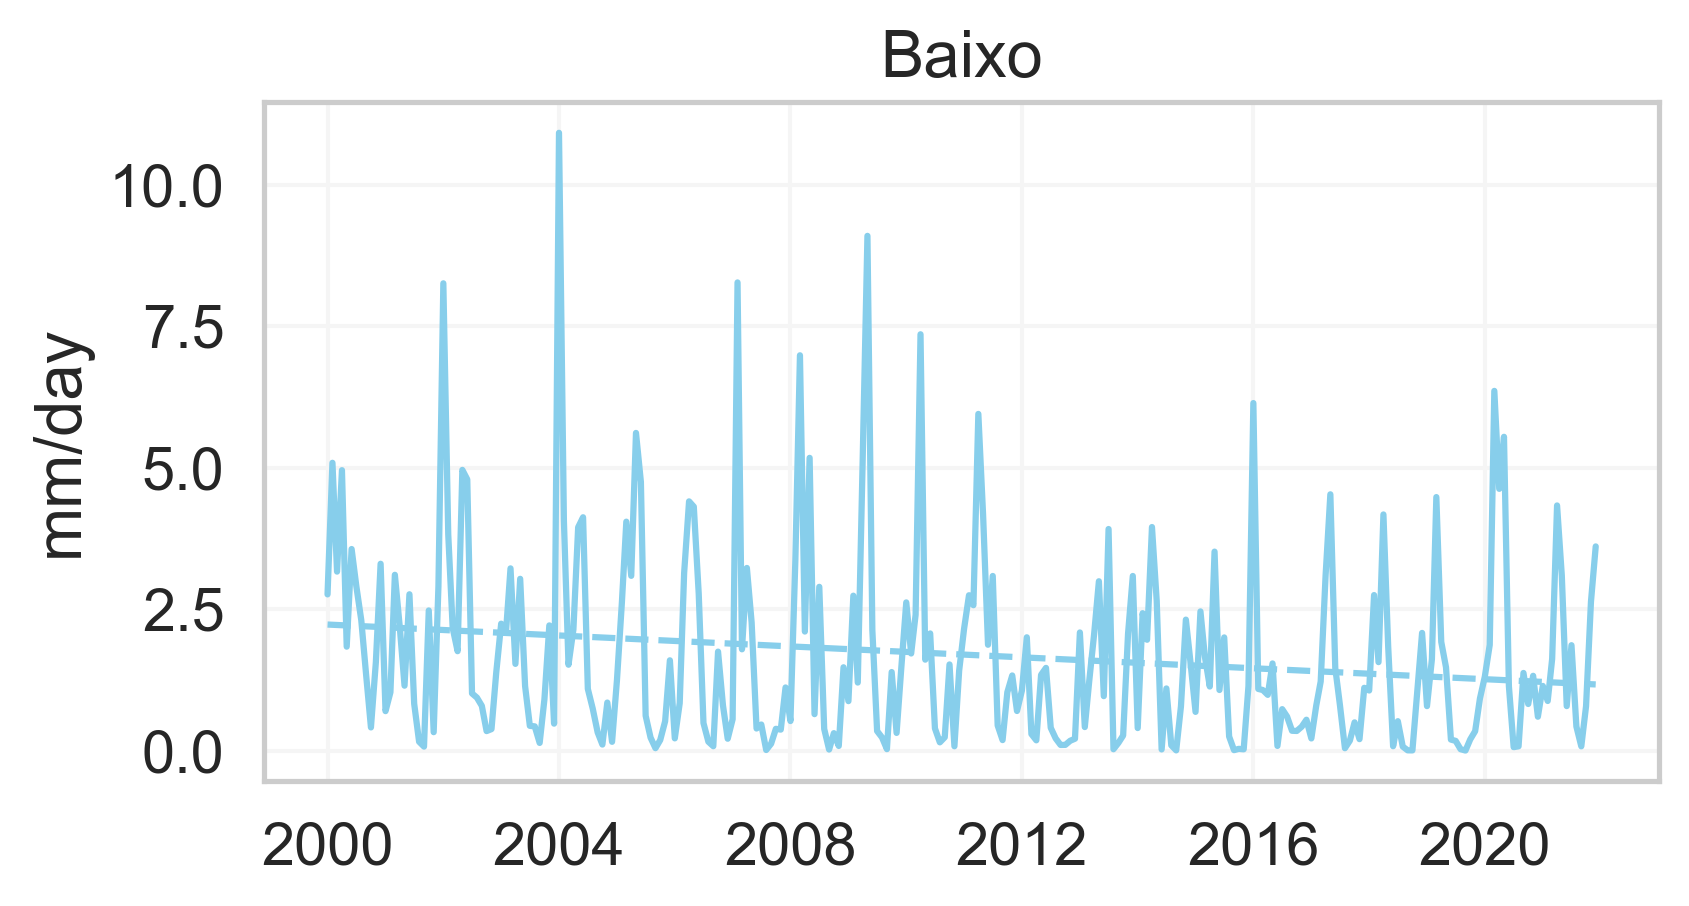

In [140]:
# Plot rainfall rate over a sub-basin (example: bai = baixo sao fracisco)
# Use find and replace to switch between basins (bai = baixo, sub = submédio, med = médio, alt = alto)

f, ax = plt.subplots(figsize=[6,3],dpi=300)

plt.grid('both', color='whitesmoke')
ax.plot(rain_bai_mean.time,rain_bai_mean.rain, color="skyblue")


# trendline (linear fitting)
z = np.polyfit(rain_bai_mean.index, rain_bai_mean.rain, 1)
p = np.poly1d(z)
ax.plot(rain_bai_mean.time,p(rain_bai_mean.index),'--',color="skyblue")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

plt.title('Baixo')
plt.ylabel('mm/day')
plt.show()

f.savefig('sf_bai_rainfall.png',bbox_inches='tight')

### Temperature

In [141]:
# Use bounds and 3D mask of São Francisco River basin to select relevant temperature data pixels

T_masked = gldas["Tair_f_inst"].sel(lon=slice(aoi_lon[0],
                                                                              aoi_lon[1]),
                                                                    lat=slice(aoi_lat[0],
                                                                              aoi_lat[1])).where(sf_mask)

# Same for sub-basins

T_bai_masked = gldas["Tair_f_inst"].sel(lon=slice(aoi_lon[0],
                                                                              aoi_lon[1]),
                                                                    lat=slice(aoi_lat[0],
                                                                              aoi_lat[1])).where(sf_bai_mask)
T_sub_masked = gldas["Tair_f_inst"].sel(lon=slice(aoi_lon[0],
                                                                              aoi_lon[1]),
                                                                    lat=slice(aoi_lat[0],
                                                                              aoi_lat[1])).where(sf_sub_mask)
T_med_masked = gldas["Tair_f_inst"].sel(lon=slice(aoi_lon[0],
                                                                              aoi_lon[1]),
                                                                    lat=slice(aoi_lat[0],
                                                                              aoi_lat[1])).where(sf_med_mask)
T_alt_masked = gldas["Tair_f_inst"].sel(lon=slice(aoi_lon[0],
                                                                              aoi_lon[1]),
                                                                    lat=slice(aoi_lat[0],
                                                                              aoi_lat[1])).where(sf_alt_mask)

In [142]:
# create spatial mean of temperature data using xarray function
# change xarray to dataframe
T_mean = T_masked.mean(["lat", "lon"])
T_mean = T_mean.to_dataframe()
T_mean.reset_index(inplace=True)

# convert K to °C
conv = -273.15
T_mean['temp'] = T_mean.Tair_f_inst+conv


y=0.002414x+(23.387848)


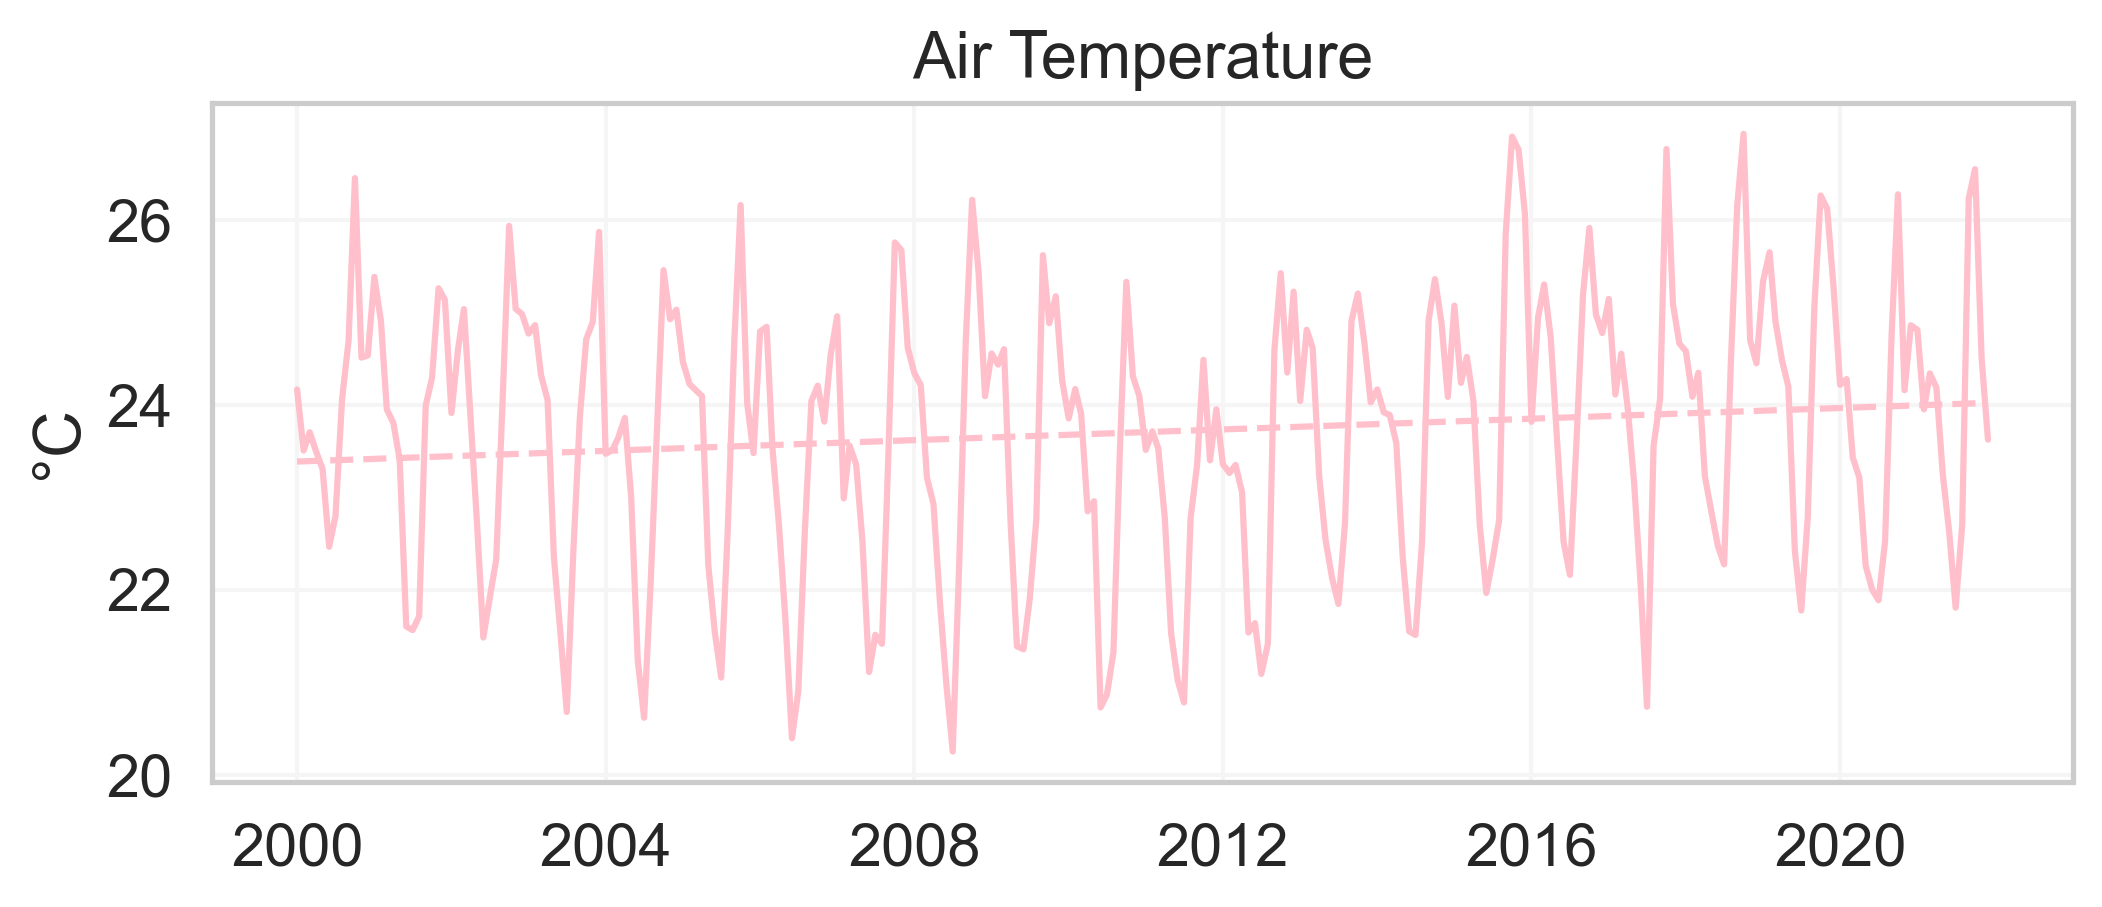

In [143]:
# Plot air temperature over the basin

f, ax = plt.subplots(figsize=[8,3],dpi=300)


plt.grid('both', color='whitesmoke')
ax.plot(T_mean.time,T_mean.temp, color="pink")

# trendline (linear fitting)
z = np.polyfit(T_mean.index, T_mean.temp, 1)
p = np.poly1d(z)
ax.plot(T_mean.time,p(T_mean.index),'--',color="pink")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

plt.title('Air Temperature')
plt.ylabel('°C')
plt.show()

# saves figure in same directory as the code file
f.savefig('sf_full_temperature.png',bbox_inches='tight')

In [144]:
# create spatial mean of temperature data using xarray function - for sub-basins
# change xarray to dataframe

#convert K to °C
conv = -273.15

T_bai_mean = T_bai_masked.mean(["lat", "lon"])
T_bai_mean = T_bai_mean.to_dataframe()
T_bai_mean.reset_index(inplace=True)
T_bai_mean['temp'] = T_bai_mean.Tair_f_inst+conv

T_sub_mean = T_sub_masked.mean(["lat", "lon"])
T_sub_mean = T_sub_mean.to_dataframe()
T_sub_mean.reset_index(inplace=True)
T_sub_mean['temp'] = T_sub_mean.Tair_f_inst+conv

T_med_mean = T_med_masked.mean(["lat", "lon"])
T_med_mean = T_med_mean.to_dataframe()
T_med_mean.reset_index(inplace=True)
T_med_mean['temp'] = T_med_mean.Tair_f_inst+conv

T_alt_mean = T_alt_masked.mean(["lat", "lon"])
T_alt_mean = T_alt_mean.to_dataframe()
T_alt_mean.reset_index(inplace=True)
T_alt_mean['temp'] = T_alt_mean.Tair_f_inst+conv

y=0.001085x+(24.970168)


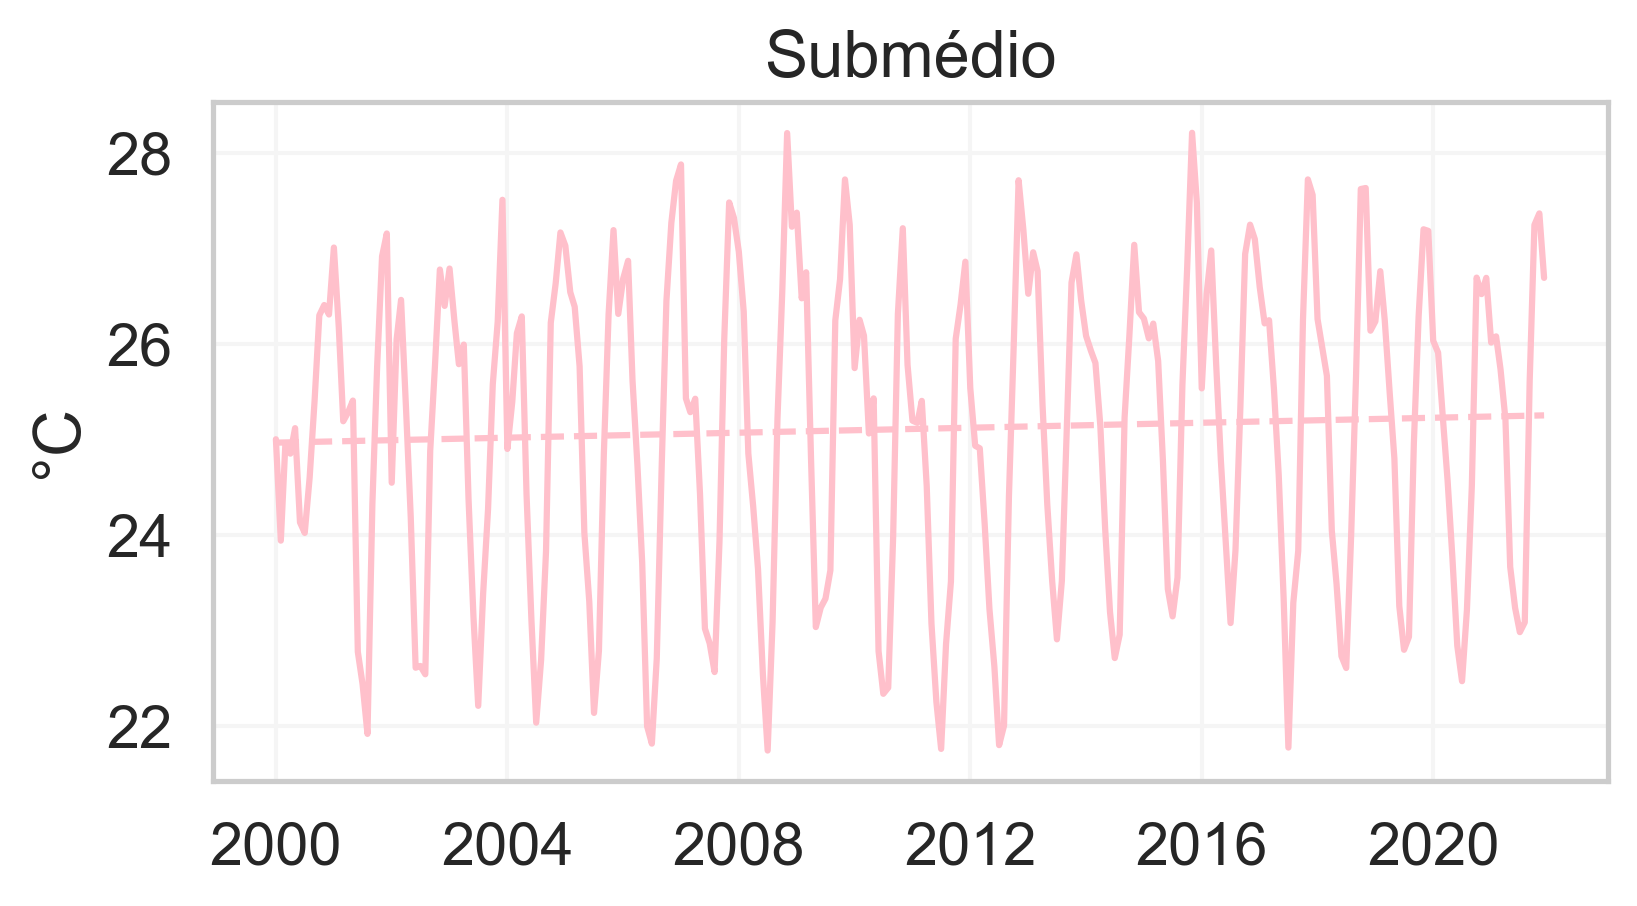

In [145]:
# Plot air temperature over a sub-basin (example: sub = submédio sao fracisco)
# Use find and replace to switch between basins (bai = baixo, sub = submédio, med = médio, alt = alto)

f, ax = plt.subplots(figsize=[6,3],dpi=300)

plt.grid('both', color='whitesmoke')
ax.plot(T_sub_mean.time,T_sub_mean.temp, color="pink")

# trendline (linear fitting)
z = np.polyfit(T_sub_mean.index, T_sub_mean.temp, 1)
p = np.poly1d(z)
ax.plot(T_sub_mean.time,p(T_sub_mean.index),'--',color="pink")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

plt.title('Submédio')
plt.ylabel('°C')
plt.show()

f.savefig('sf_sub_temperature.png',bbox_inches='tight')

### Evapotranspiration

In [146]:
# Use bounds and 3D mask of São Francisco River basin to select relevant evapotranspiration data pixels

et_masked = gldas["Evap_tavg"].sel(lon=slice(aoi_lon[0],
                                                                              aoi_lon[1]),
                                                                    lat=slice(aoi_lat[0],
                                                                              aoi_lat[1])).where(sf_mask)

# Same for sub-basins
et_bai_masked = gldas["Evap_tavg"].sel(lon=slice(aoi_lon[0],
                                                                              aoi_lon[1]),
                                                                    lat=slice(aoi_lat[0],
                                                                              aoi_lat[1])).where(sf_bai_mask)
et_sub_masked = gldas["Evap_tavg"].sel(lon=slice(aoi_lon[0],
                                                                              aoi_lon[1]),
                                                                    lat=slice(aoi_lat[0],
                                                                              aoi_lat[1])).where(sf_sub_mask)
et_med_masked = gldas["Evap_tavg"].sel(lon=slice(aoi_lon[0],
                                                                              aoi_lon[1]),
                                                                    lat=slice(aoi_lat[0],
                                                                              aoi_lat[1])).where(sf_med_mask)
et_alt_masked = gldas["Evap_tavg"].sel(lon=slice(aoi_lon[0],
                                                                              aoi_lon[1]),
                                                                    lat=slice(aoi_lat[0],
                                                                              aoi_lat[1])).where(sf_alt_mask)

In [147]:
# create spatial mean of evapotranspiration data using xarray function
# change xarray to dataframe
et_mean = et_masked.mean(["lat", "lon"])
et_mean = et_mean.to_dataframe()
et_mean.reset_index(inplace=True)

# 1kg/m2/s = 86400mm/day
conv = 86400
et_mean['et'] = et_mean.Evap_tavg*conv

y=-0.001138x+(2.225384)


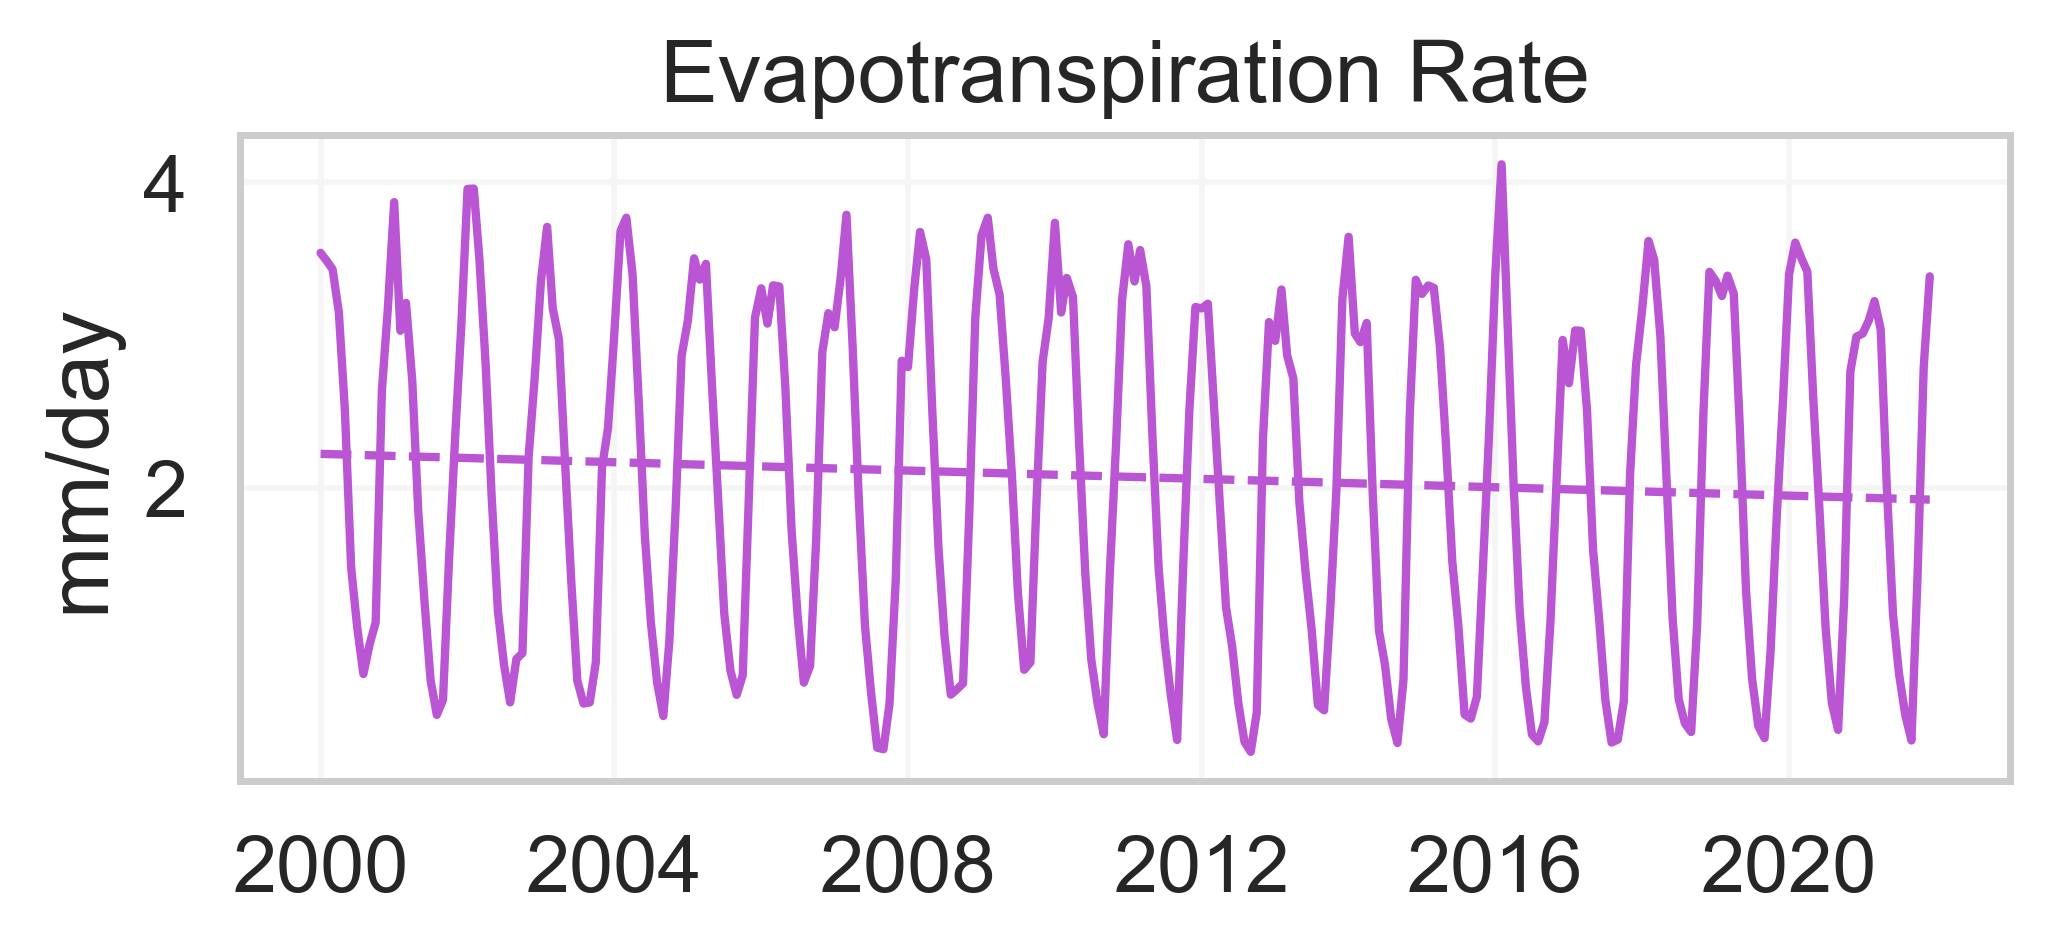

In [148]:
# Plot evapotranspiration over full basin

sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=[5.71,2.14],dpi=400)

plt.grid('both', color='whitesmoke')
ax.plot(et_mean.time,et_mean.et, color="mediumorchid")


# trendline (linear fitting)
z = np.polyfit(et_mean.index, et_mean.et, 1)
p = np.poly1d(z)
ax.plot(et_mean.time,p(et_mean.index),'--',color="mediumorchid")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

plt.title('Evapotranspiration Rate')
plt.ylabel('mm/day')
plt.show()

# saves figure in same directory as the code file
f.savefig('sf_full_et.png',bbox_inches='tight')

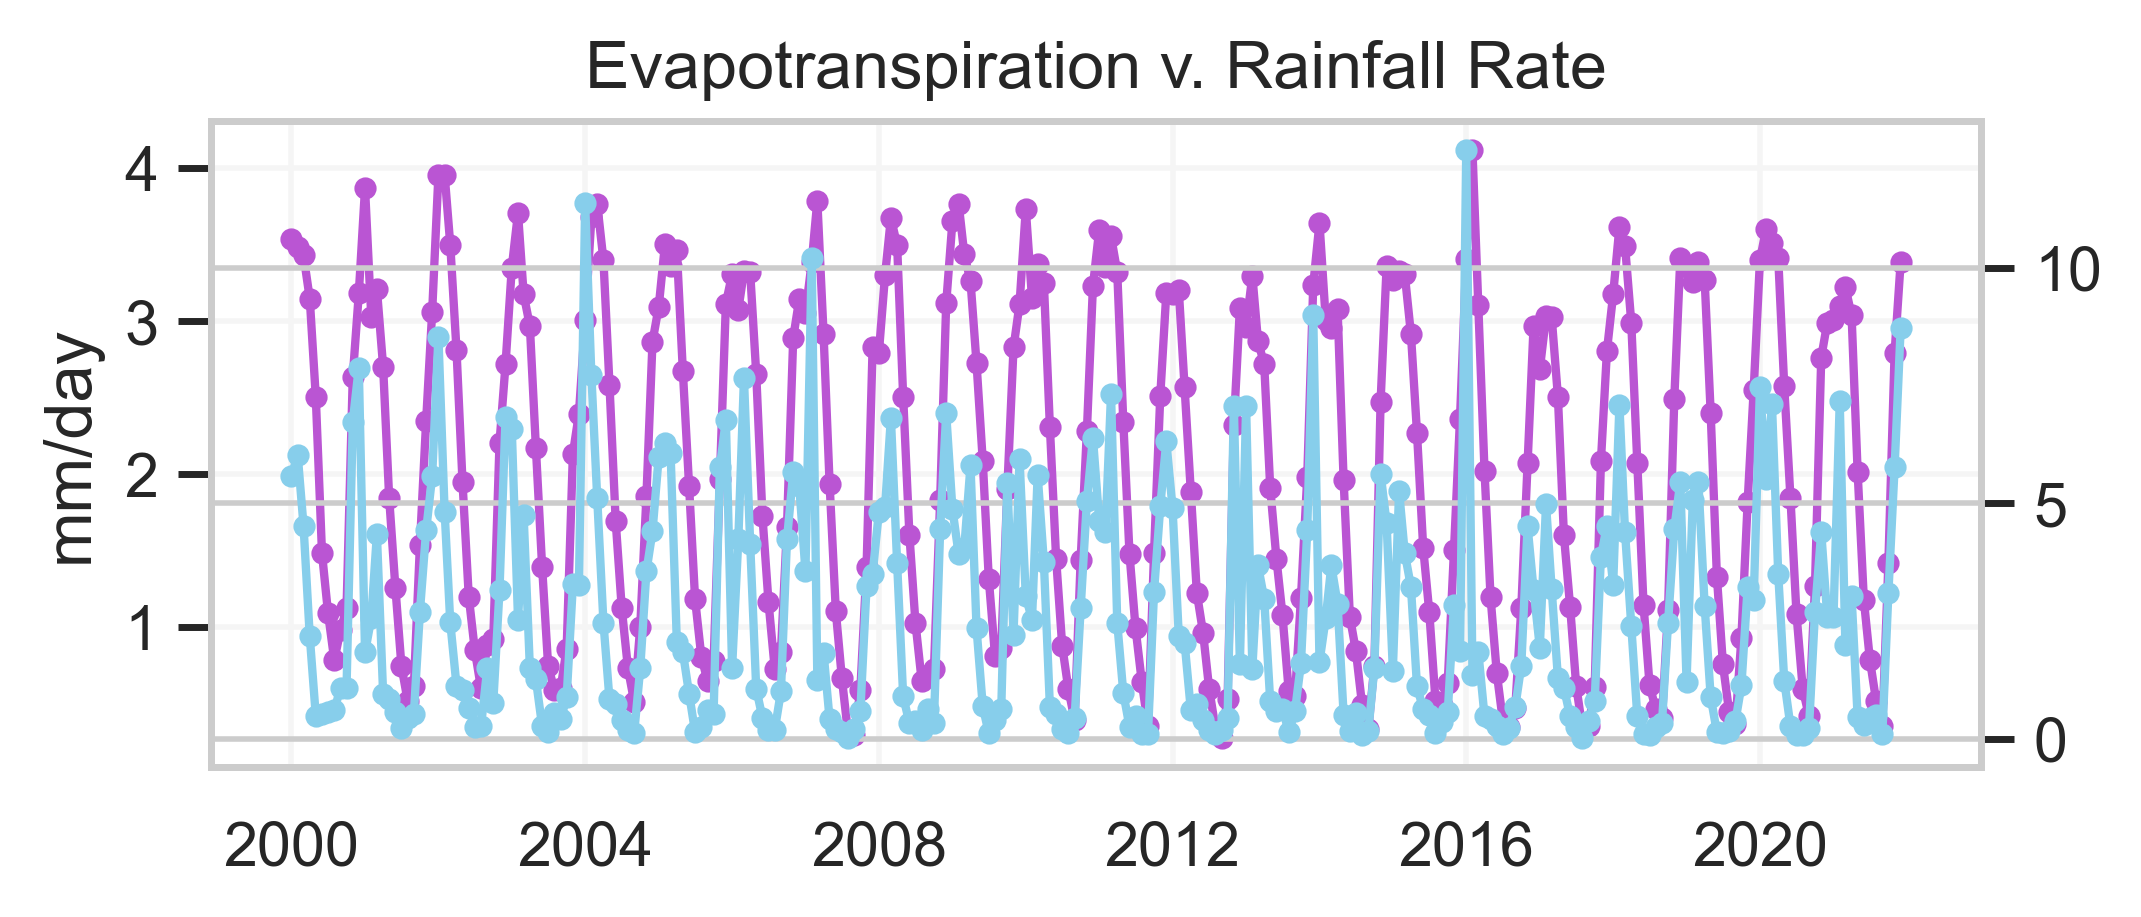

In [182]:
# Plot evapotranspiration v. tempaerature over the basin --> can make other comparison graphs!

sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=[5.71,2.14],dpi=400)

plt.grid('both', color='whitesmoke')
ax.plot(et_mean.time,et_mean.et, color="mediumorchid", marker='.')
plt.ylabel('mm/day')


# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
ax2.plot(rain_mean.time,rain_mean.rain, color="skyblue", marker='.')

plt.title('Evapotranspiration v. Rainfall Rate')

plt.show()

# saves figure in same directory as the code file
f.savefig('sf_full_et_rain.png',bbox_inches='tight')

In [150]:
# same but for sub-basins
# create spatial mean of evapotranspiration data using xarray function


# 1kg/m2/s = 86400mm/day
conv = 86400

et_bai_mean = et_bai_masked.mean(["lat", "lon"])
et_bai_mean = et_bai_mean.to_dataframe()
et_bai_mean.reset_index(inplace=True)
et_bai_mean['et'] = et_bai_mean.Evap_tavg *conv

et_sub_mean = et_sub_masked.mean(["lat", "lon"])
et_sub_mean = et_sub_mean.to_dataframe()
et_sub_mean.reset_index(inplace=True)
et_sub_mean['et'] = et_sub_mean.Evap_tavg *conv

et_med_mean = et_med_masked.mean(["lat", "lon"])
et_med_mean = et_med_mean.to_dataframe()
et_med_mean.reset_index(inplace=True)
et_med_mean['et'] = et_med_mean.Evap_tavg *conv

et_alt_mean = et_alt_masked.mean(["lat", "lon"])
et_alt_mean = et_alt_mean.to_dataframe()
et_alt_mean.reset_index(inplace=True)
et_alt_mean['et'] = et_alt_mean.Evap_tavg *conv


y=-0.002331x+(1.842500)


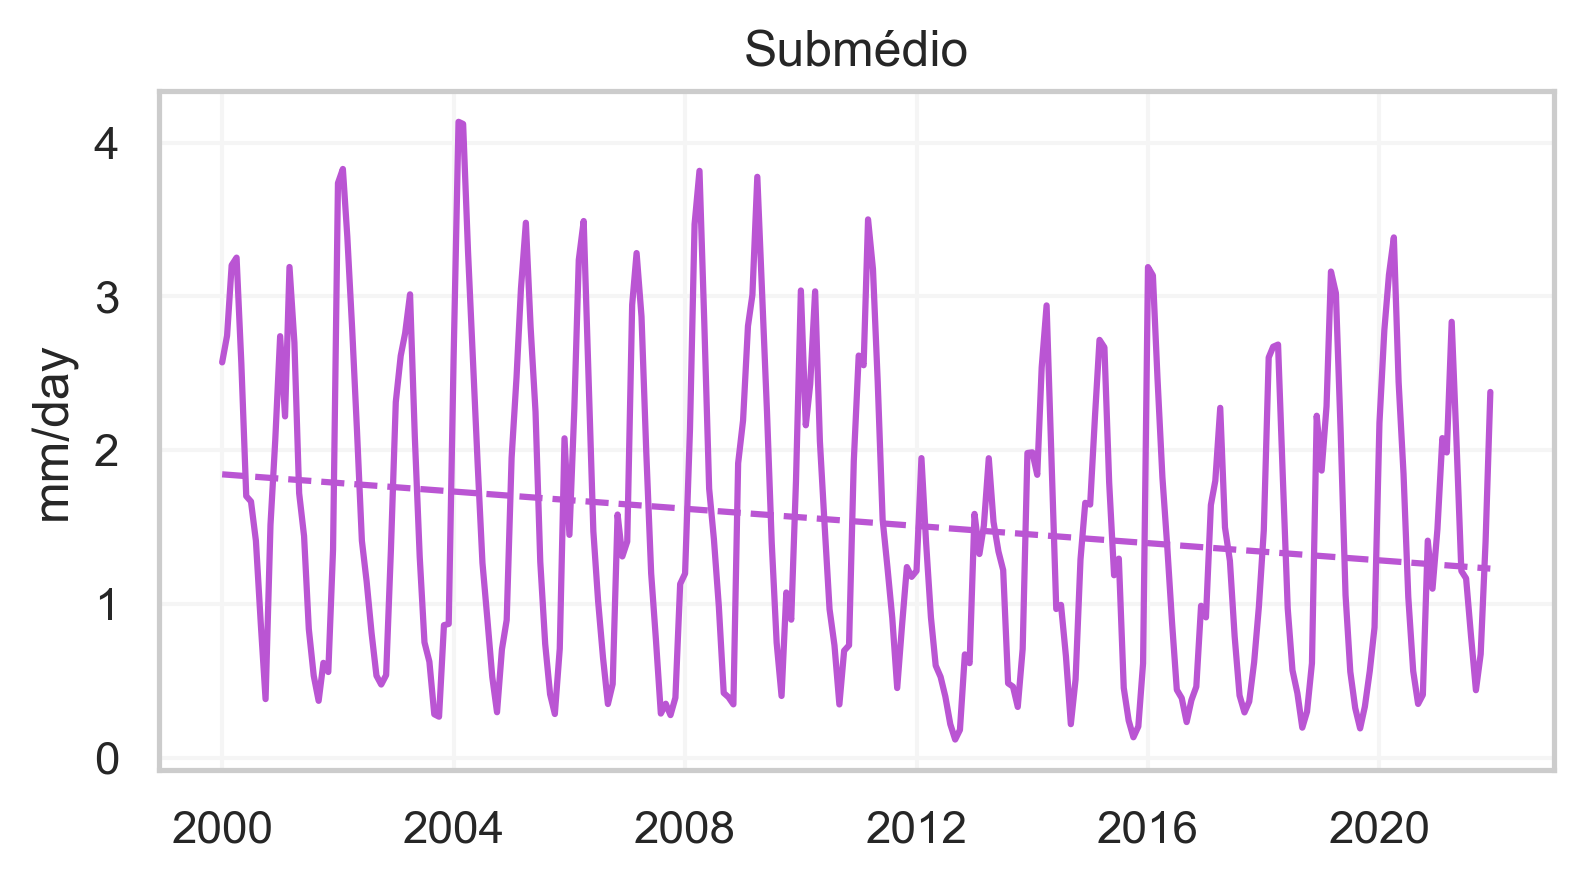

In [191]:
# Plot evapotranspiration over a sub-basin (example: sub = submédio sao fracisco)
# Use find and replace to switch between basins (sub = subxo, sub = submédio, sub = médio, sub = subo)

f, ax = plt.subplots(figsize=[6,3],dpi=300)

plt.grid('both', color='whitesmoke')
ax.plot(et_sub_mean.time,et_sub_mean.et, color="mediumorchid")


# trendline (linear fitting)
z = np.polyfit(et_sub_mean.index, et_sub_mean.et, 1)
p = np.poly1d(z)
ax.plot(et_sub_mean.time,p(et_sub_mean.index),'--',color="mediumorchid")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

plt.title('Submédio')
plt.ylabel('mm/day')
plt.show()

f.savefig('sf_sub_et.png',bbox_inches='tight')

### Boxplots (seasonality!)

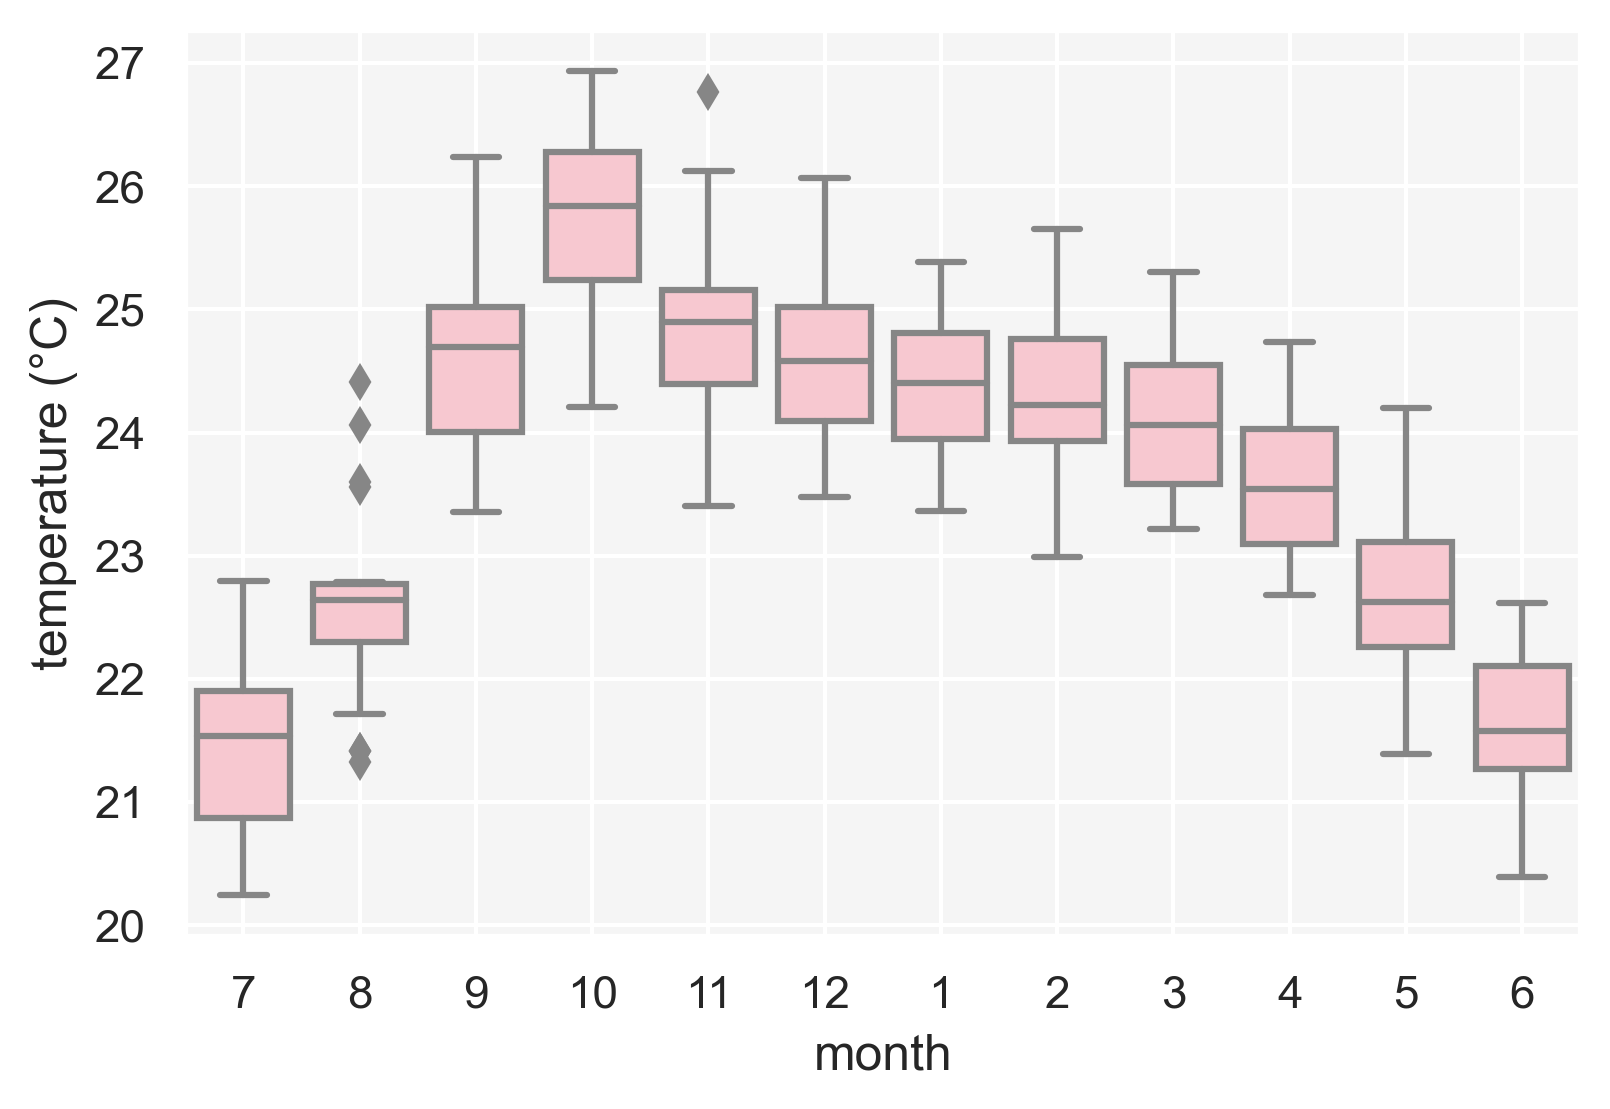

In [152]:
# Temperature boxplot
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300,'axes.facecolor':'whitesmoke', })
T_mean['month'] = T_mean.time.dt.month
ax = sns.boxplot(x="month", y="temp", data=T_mean, color='pink', order=[7,8,9,10,11,12,1,2,3,4,5,6])
ax.set_ylabel('temperature (°C)')
plt.grid()
ax.grid(True)

plt.savefig('sf_temperature_boxplot.png')

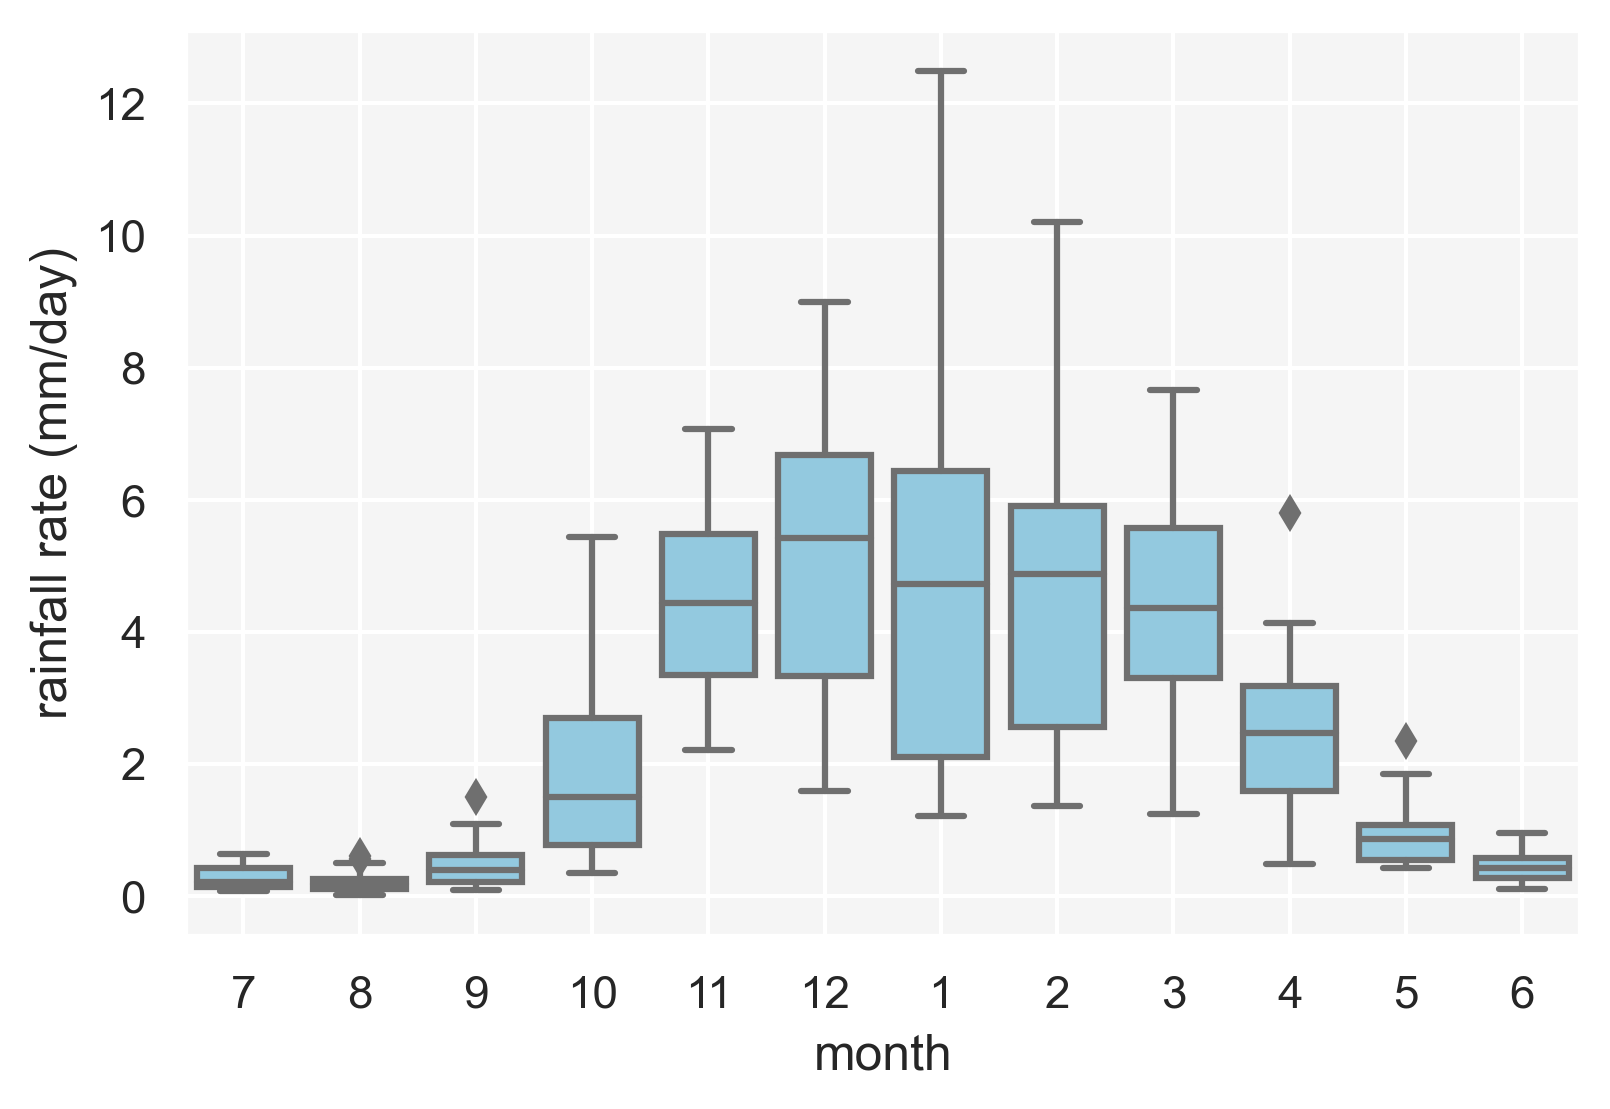

In [153]:
# Rainfall boxplot
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300,'axes.facecolor':'whitesmoke'})
rain_mean['month'] = rain_mean.time.dt.month

ax = sns.boxplot(x="month", y="rain", data=rain_mean, color='skyblue', order=[7,8,9,10,11,12,1,2,3,4,5,6])
ax.set_ylabel('rainfall rate (mm/day)')
ax.grid(True)

plt.savefig('sf_rain_boxplot.png')

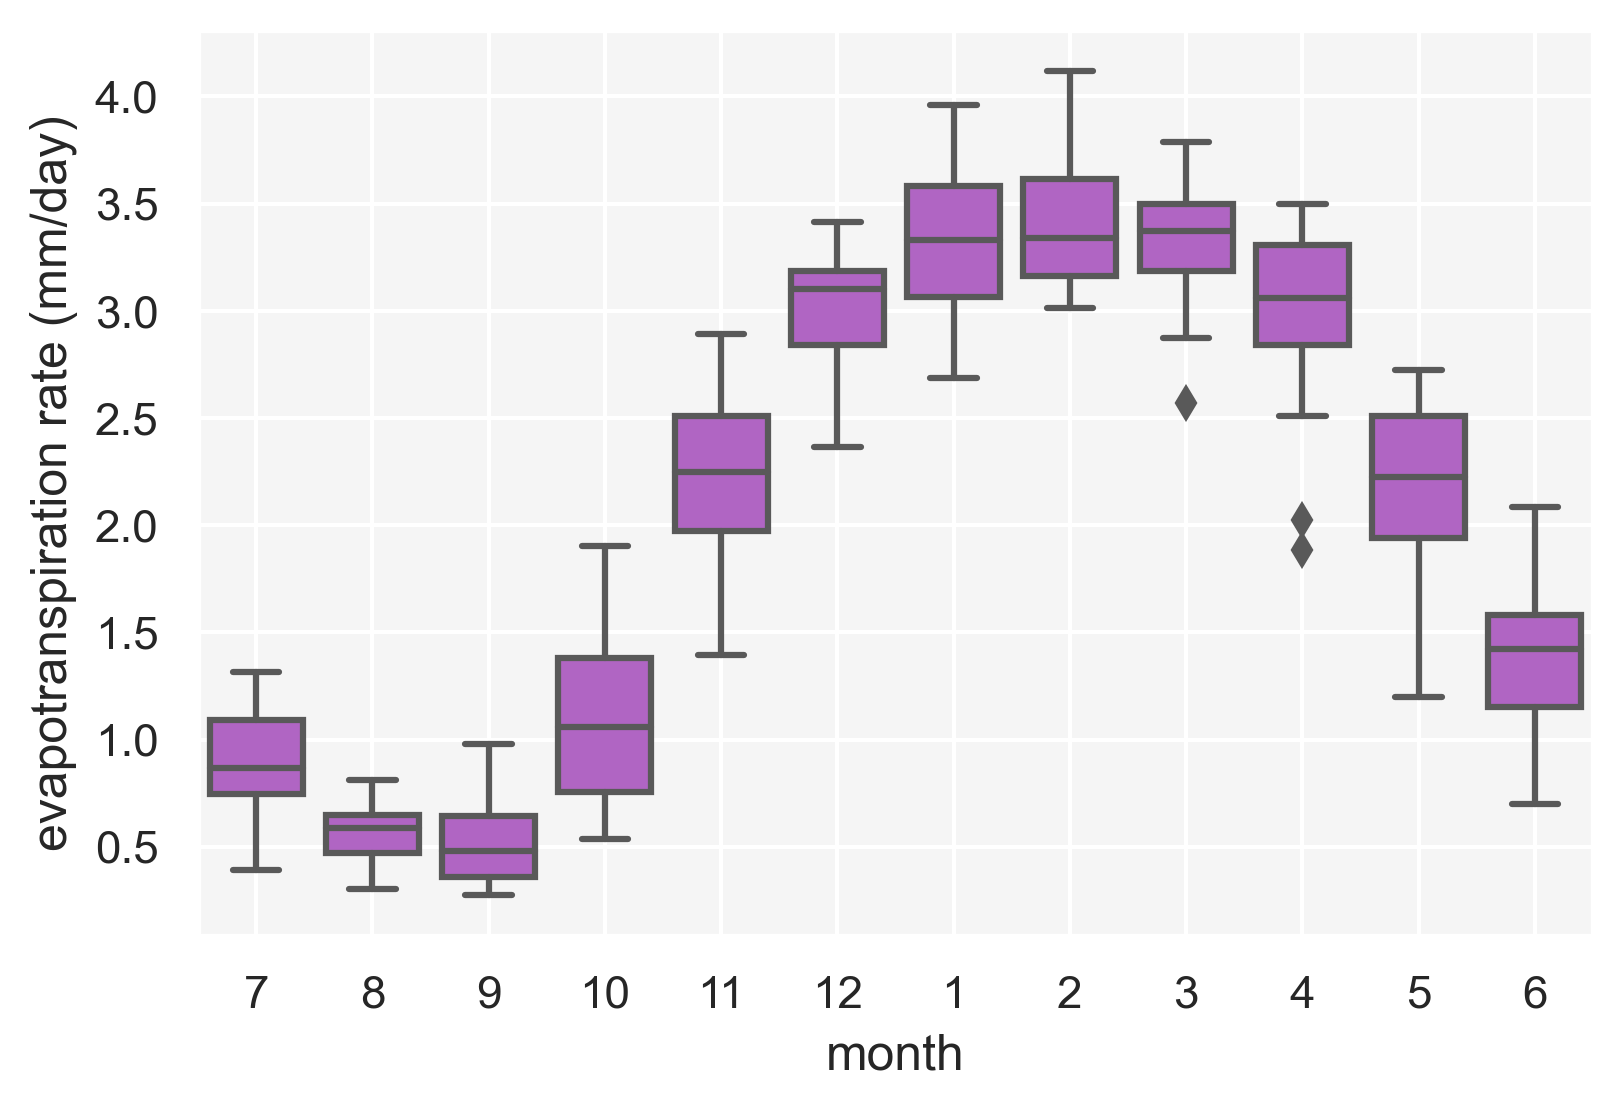

In [154]:
# Evapotranspiration boxplot
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300,'axes.facecolor':'whitesmoke'})
et_mean['month'] = et_mean.time.dt.month

ax = sns.boxplot(x="month", y="et", data=et_mean, color='mediumorchid', order=[7,8,9,10,11,12,1,2,3,4,5,6])
ax.set_ylabel('evapotranspiration rate (mm/day)')
ax.grid(True)

plt.savefig('sf_et_boxplot.png')

### Estimating water used by center-pivot irrigation

In [226]:
# Read in center pivot area data
url =  ("/Users/mariafleury/Desktop/Senior Thesis/coding/climate+irrig/irrigação são francisco.csv")
pivo_sf = pd.read_csv(url)

url =  ("/Users/mariafleury/Desktop/Senior Thesis/coding/climate+irrig/irrigação baixo.csv")
pivo_bai = pd.read_csv(url)

url =  ("/Users/mariafleury/Desktop/Senior Thesis/coding/climate+irrig/irrigação médio.csv")
pivo_med = pd.read_csv(url)

url =  ("/Users/mariafleury/Desktop/Senior Thesis/coding/climate+irrig/irrigação submédio.csv")
pivo_sub = pd.read_csv(url)

url =  ("/Users/mariafleury/Desktop/Senior Thesis/coding/climate+irrig/irrigação alto.csv")
pivo_alt = pd.read_csv(url)

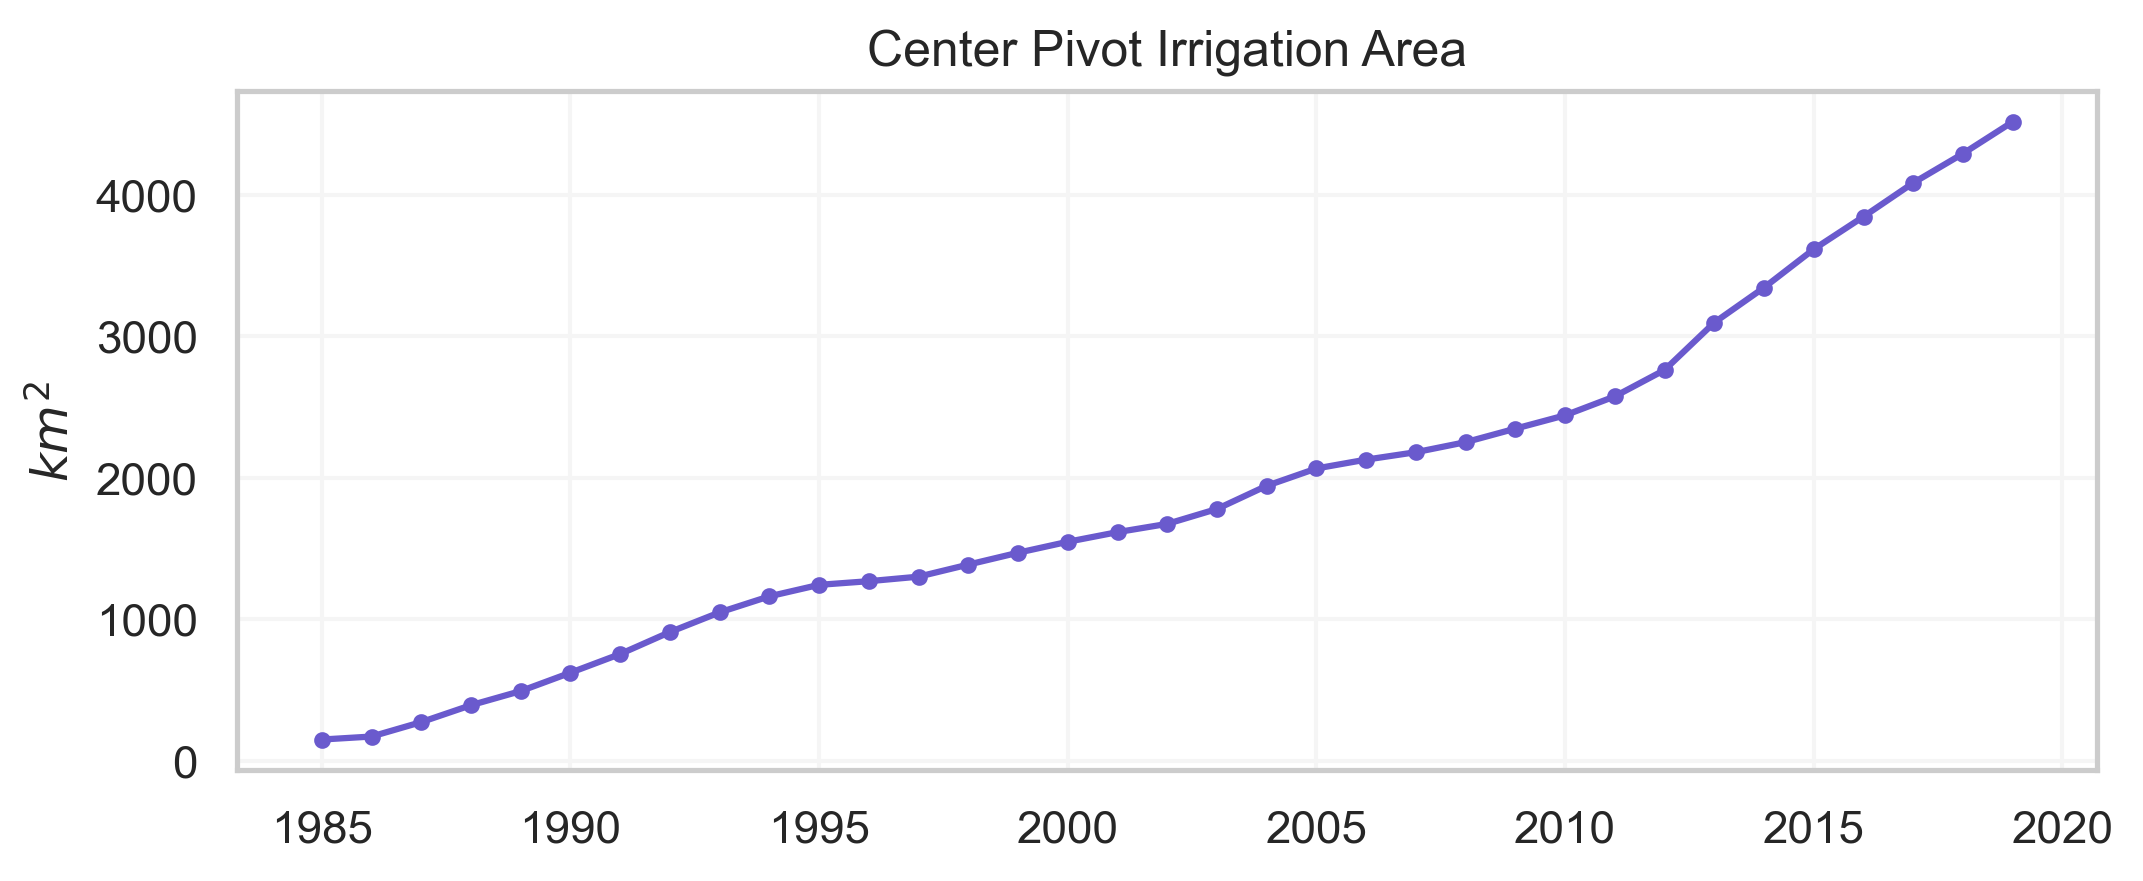

In [227]:
# Plot center-pivot irrigation area timeseries over full basin
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=[8,3],dpi=300)

plt.grid('both', color='whitesmoke')
ax.plot(pivo_sf.Ano,pivo_sf['Pivô central']*0.01, color="slateblue", marker='.')

plt.title('Center Pivot Irrigation Area')
plt.ylabel('$km^2$')
#plt.show()

plt.savefig('sf_pivo_area.png')

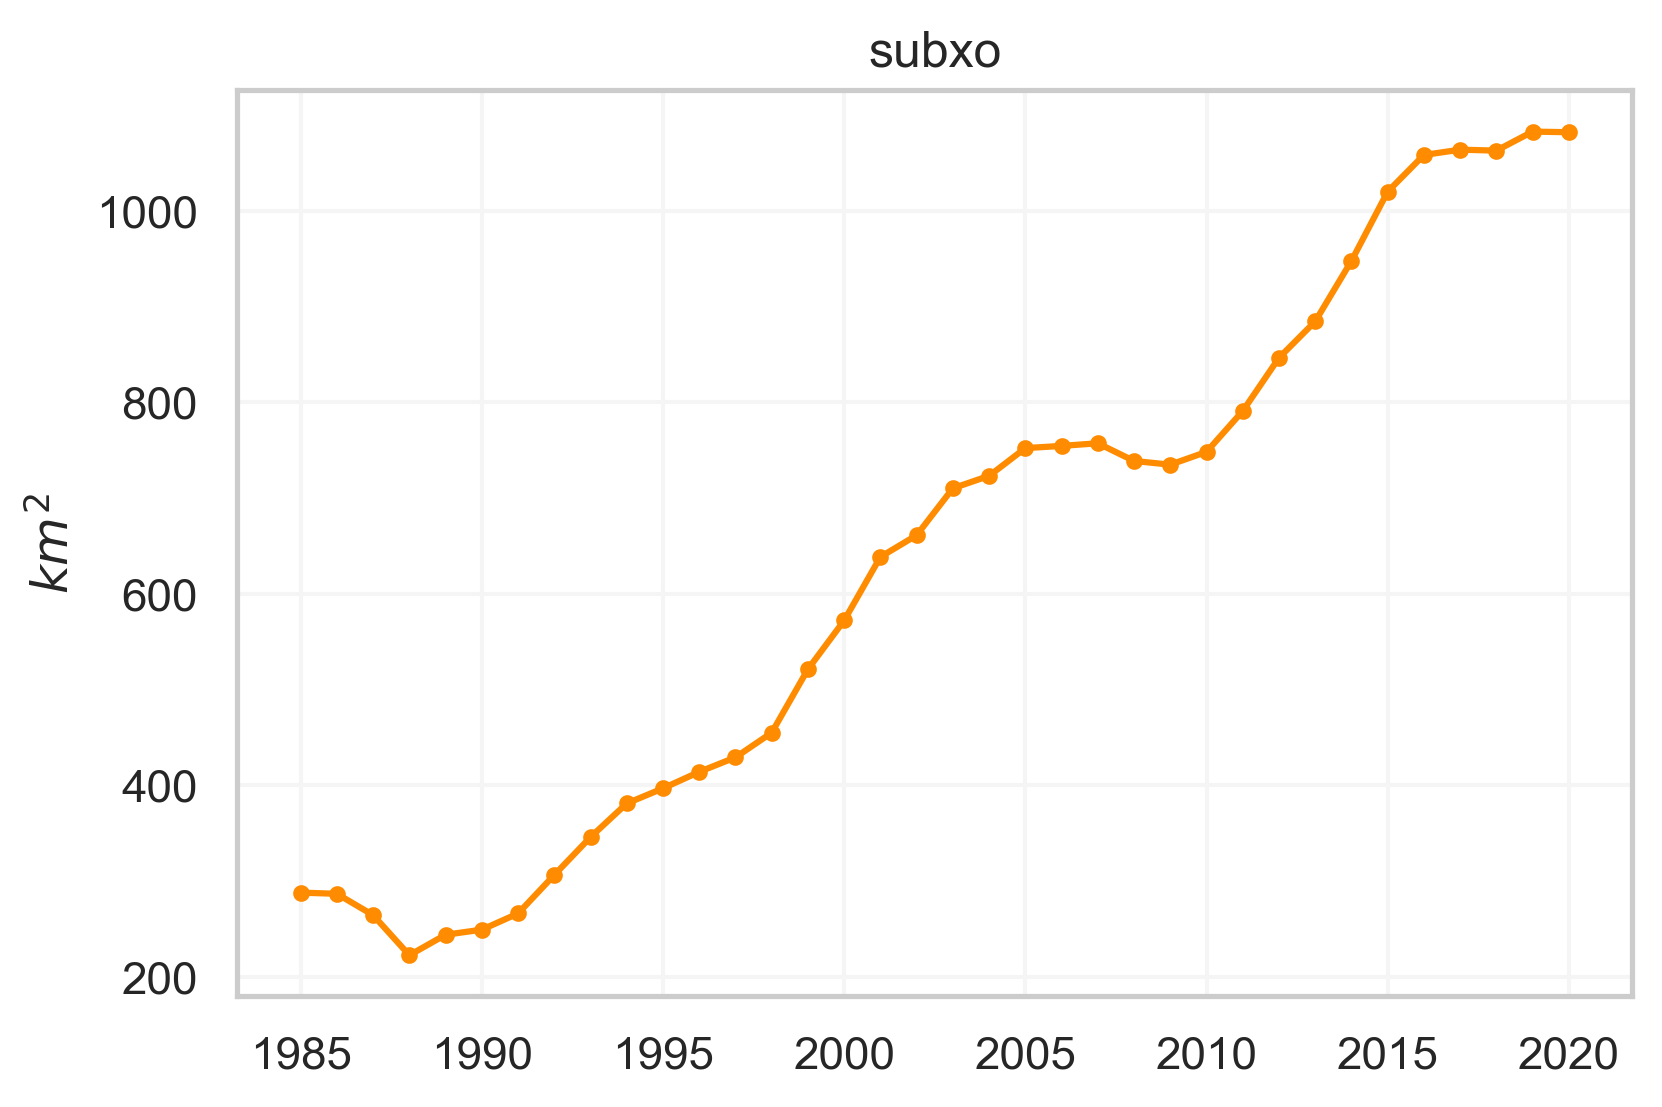

In [280]:
# Plot center-pivot irrigation area timeseries over sub-basins

sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=[6,4],dpi=300)

plt.grid('both', color='whitesmoke')
ax.plot(pivo_sub.Ano,pivo_sub['Outros sistemas']*0.01, color="darkorange", marker='.')
plt.title('subxo')
plt.ylabel('$km^2$')
# plt.show()

plt.savefig('sf_pivo_sub.png')

In [282]:
pivo_alt

,Ano,Pivô central,Outros sistemas
0,1985,2467,467
1,1986,2573,312
2,1987,5230,319
3,1988,6652,198
4,1989,7580,148
5,1990,9337,129
6,1991,9676,216
7,1992,10014,222
8,1993,10359,200
9,1994,10607,102


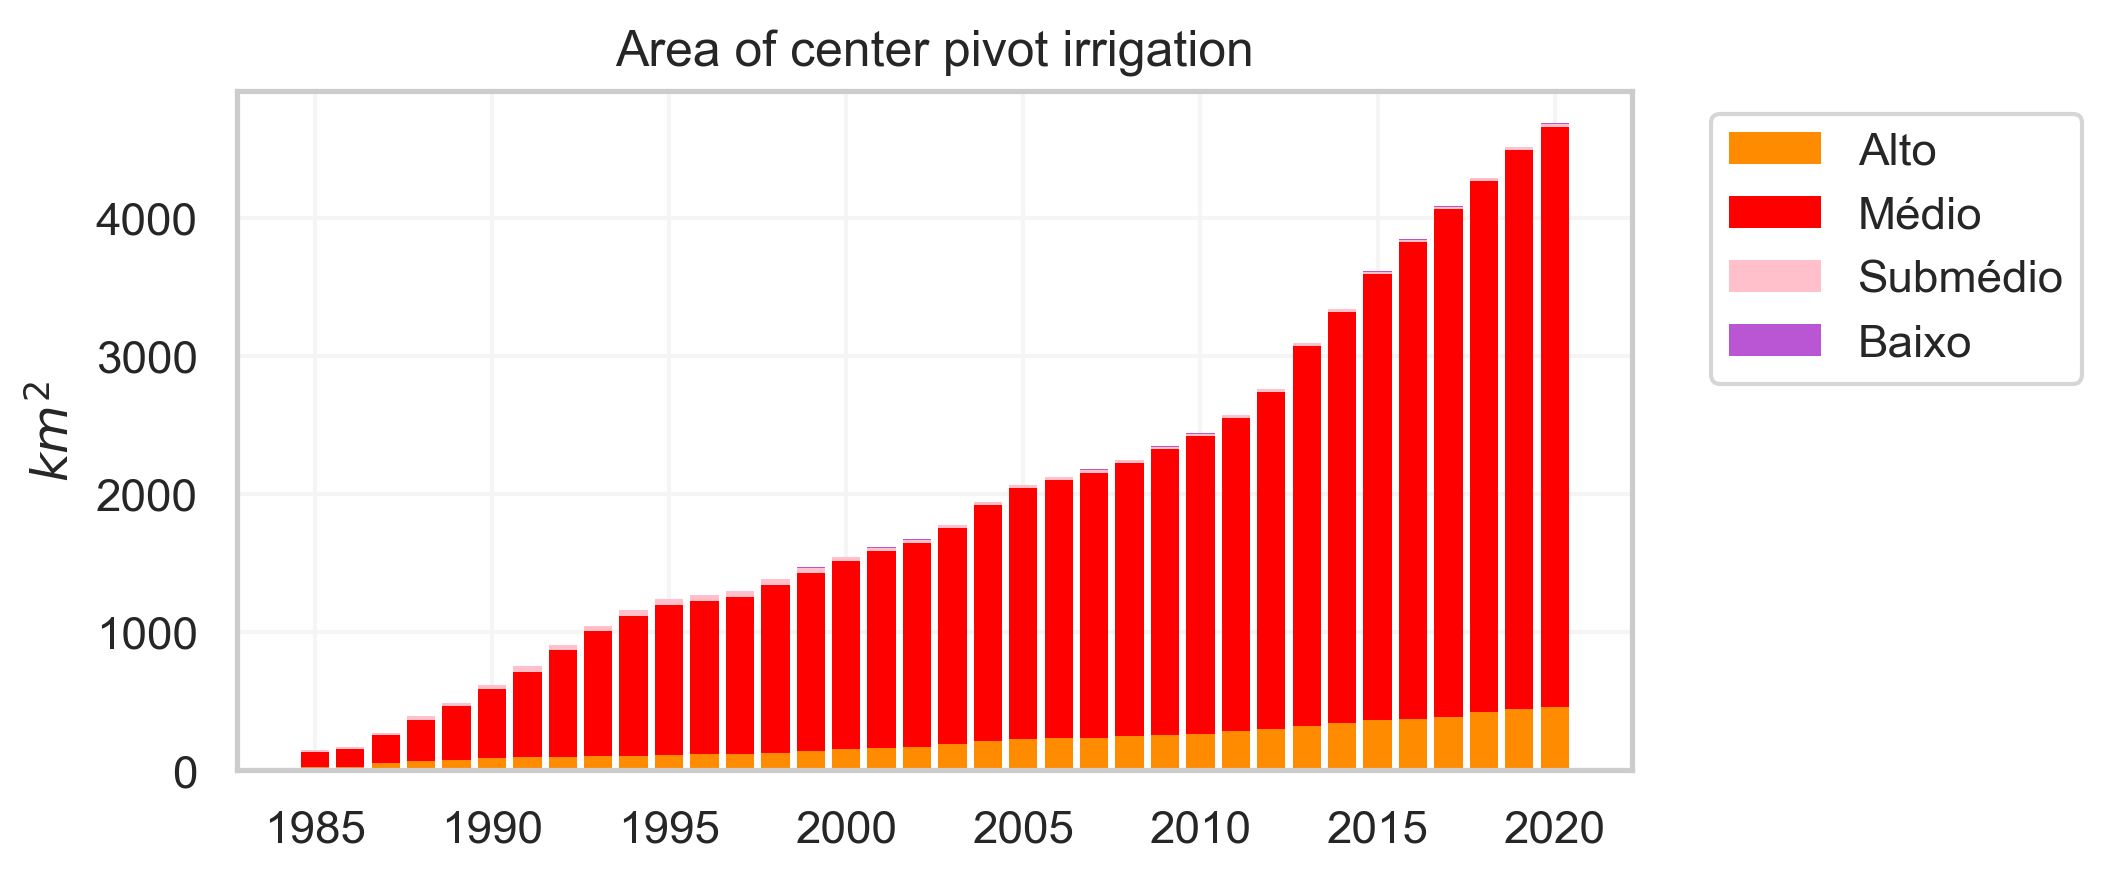

In [229]:
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=[6,3],dpi=300)

plt.grid('both', color='whitesmoke')
ax.bar(pivo_alt.Ano,pivo_alt['Pivô central']*0.01,0.8, color='darkorange',edgecolor='none')
ax.bar(pivo_med.Ano,pivo_med['Pivô central']*0.01,0.8, color='red',edgecolor='none',bottom=(pivo_alt['Pivô central'])*0.01)
ax.bar(pivo_sub.Ano,pivo_sub['Pivô central']*0.01,0.8, color='pink',edgecolor='none',bottom=(pivo_alt['Pivô central']+pivo_med['Pivô central'])*0.01)
ax.bar(pivo_bai.Ano,pivo_bai['Pivô central']*0.01,0.8, color='mediumorchid',edgecolor='none',bottom=(pivo_alt['Pivô central']+pivo_sub['Pivô central']+pivo_med['Pivô central'])*0.01)
plt.title('Area of center pivot irrigation')
plt.ylabel('$km^2$')
plt.legend(['Alto','Médio','Submédio','Baixo'],bbox_to_anchor=(1.04,1), loc="upper left")
# plt.show()

plt.savefig('sf_pivo_bar.png',bbox_inches='tight', transparent=True)

In [230]:
 # calculating water depth based off basin average
eff = 0.85
diff = (et_mean.et - rain_mean.rain)/eff
z = np.zeros(len(diff))
D = np.maximum(diff,z)
t = et_mean.time

irrig = pd.DataFrame({'time': t, 'depth': D}, columns=['time', 'depth'])
irrig['Ano'] = irrig.time.dt.year
irrig

,time,depth,Ano
0,2000-01-01,0.000000,2000
1,2000-02-01,0.000000,2000
2,2000-03-01,0.000000,2000
3,2000-04-01,1.136213,2000
4,2000-05-01,2.368294,2000
...,...,...,...
259,2021-08-01,0.019483,2021
260,2021-09-01,0.292632,2021
261,2021-10-01,0.000000,2021
262,2021-11-01,0.000000,2021


In [231]:
 # calculating water depth based off sub-basin averages
eff = 0.85

#baixo
diff = (et_bai_mean.et - rain_bai_mean.rain)/eff
z = np.zeros(len(diff))
D_bai = np.maximum(diff,z)
t = et_bai_mean.time

irrig_bai = pd.DataFrame({'time': t, 'depth': D_bai}, columns=['time', 'depth'])
irrig_bai['Ano'] = irrig_bai.time.dt.year

#submédio
diff = (et_sub_mean.et - rain_sub_mean.rain)/eff
z = np.zeros(len(diff))
D_sub = np.maximum(diff,z)
t = et_sub_mean.time

irrig_sub = pd.DataFrame({'time': t, 'depth': D_sub}, columns=['time', 'depth'])
irrig_sub['Ano'] = irrig_sub.time.dt.year

#Médio
diff = (et_med_mean.et - rain_med_mean.rain)/eff
z = np.zeros(len(diff))
D_med = np.maximum(diff,z)
t = et_med_mean.time

irrig_med = pd.DataFrame({'time': t, 'depth': D_med}, columns=['time', 'depth'])
irrig_med['Ano'] = irrig_med.time.dt.year

#Alto
diff = (et_alt_mean.et - rain_alt_mean.rain)/eff
z = np.zeros(len(diff))
D_alt = np.maximum(diff,z)
t = et_alt_mean.time

irrig_alt = pd.DataFrame({'time': t, 'depth': D_alt}, columns=['time', 'depth'])
irrig_alt['Ano'] = irrig_alt.time.dt.year

y=-0.000302x+(0.559737)


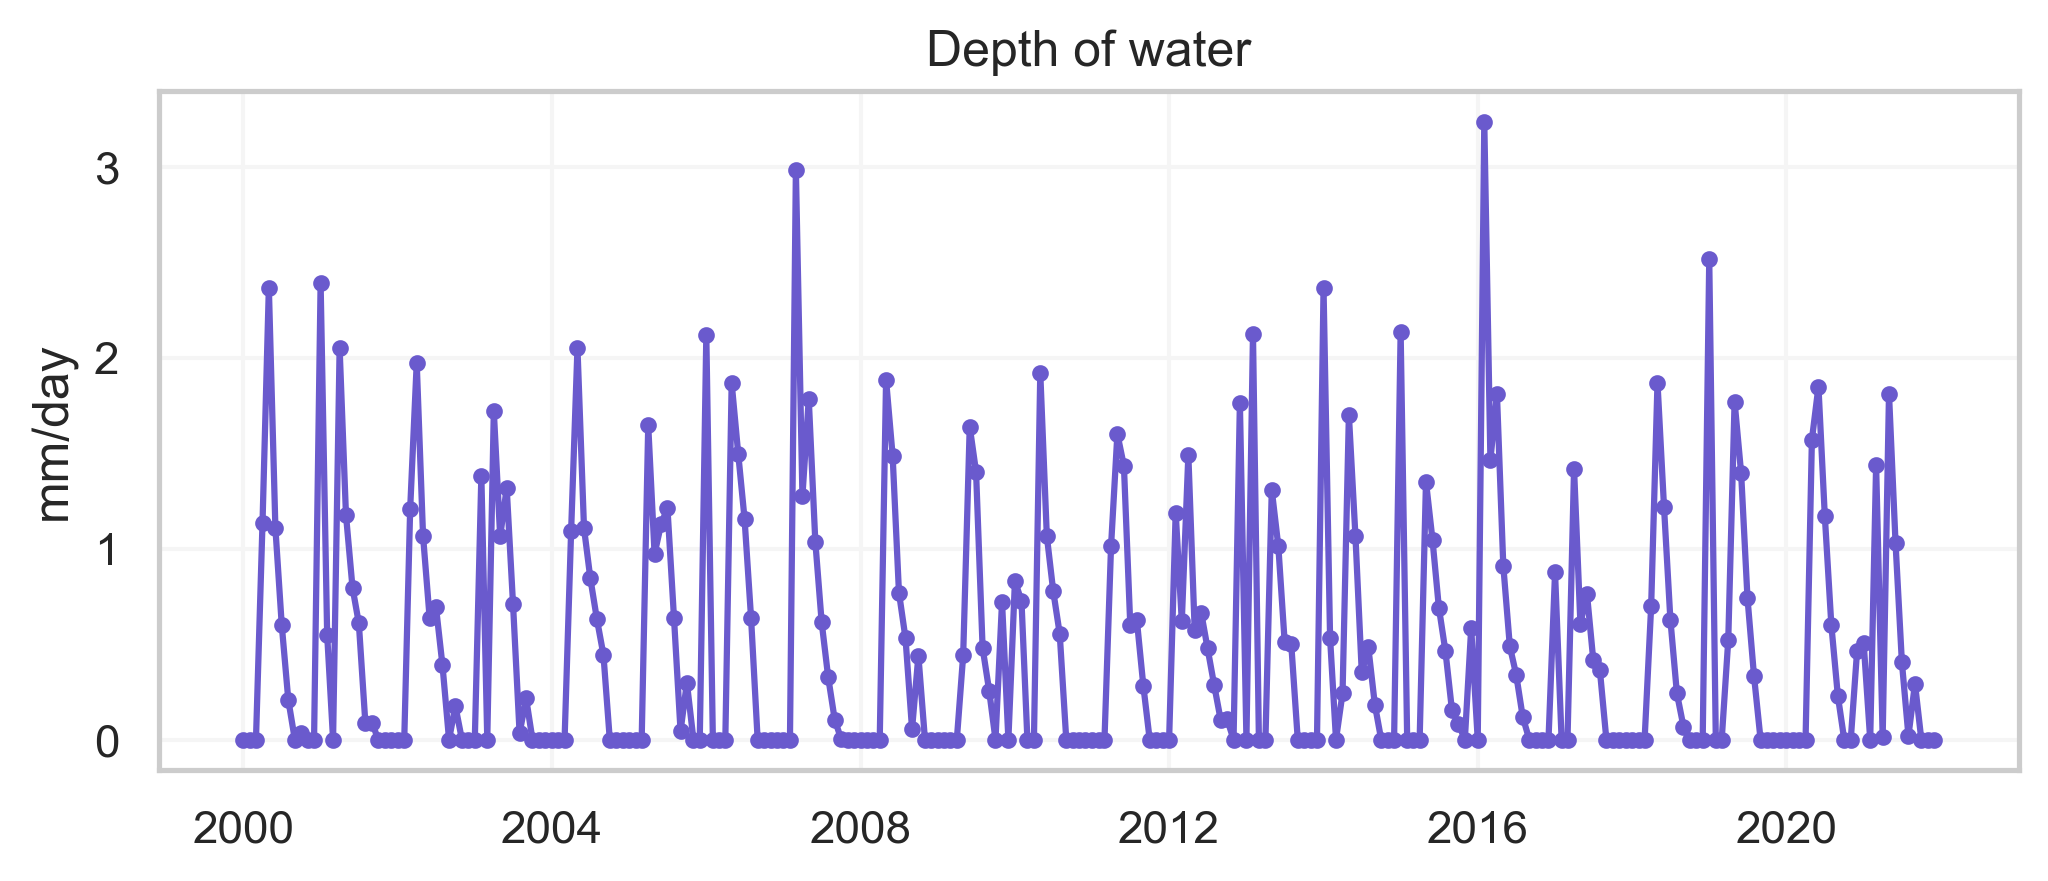

In [284]:
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=[8,3],dpi=300)

plt.grid('both', color='whitesmoke')
ax.plot(irrig.time,irrig.depth, color="slateblue", marker='.')


# trendline (linear fitting)
z = np.polyfit(irrig.index, irrig.depth, 1)
p = np.poly1d(z)
# ax.plot(irrig.time,p(irrig.index),'--',color="slateblue")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

plt.title('Depth of water')
plt.ylabel('mm/day')
#plt.show()

plt.savefig('sf_irrig_depth.png')

y=-0.000279x+(0.626639)


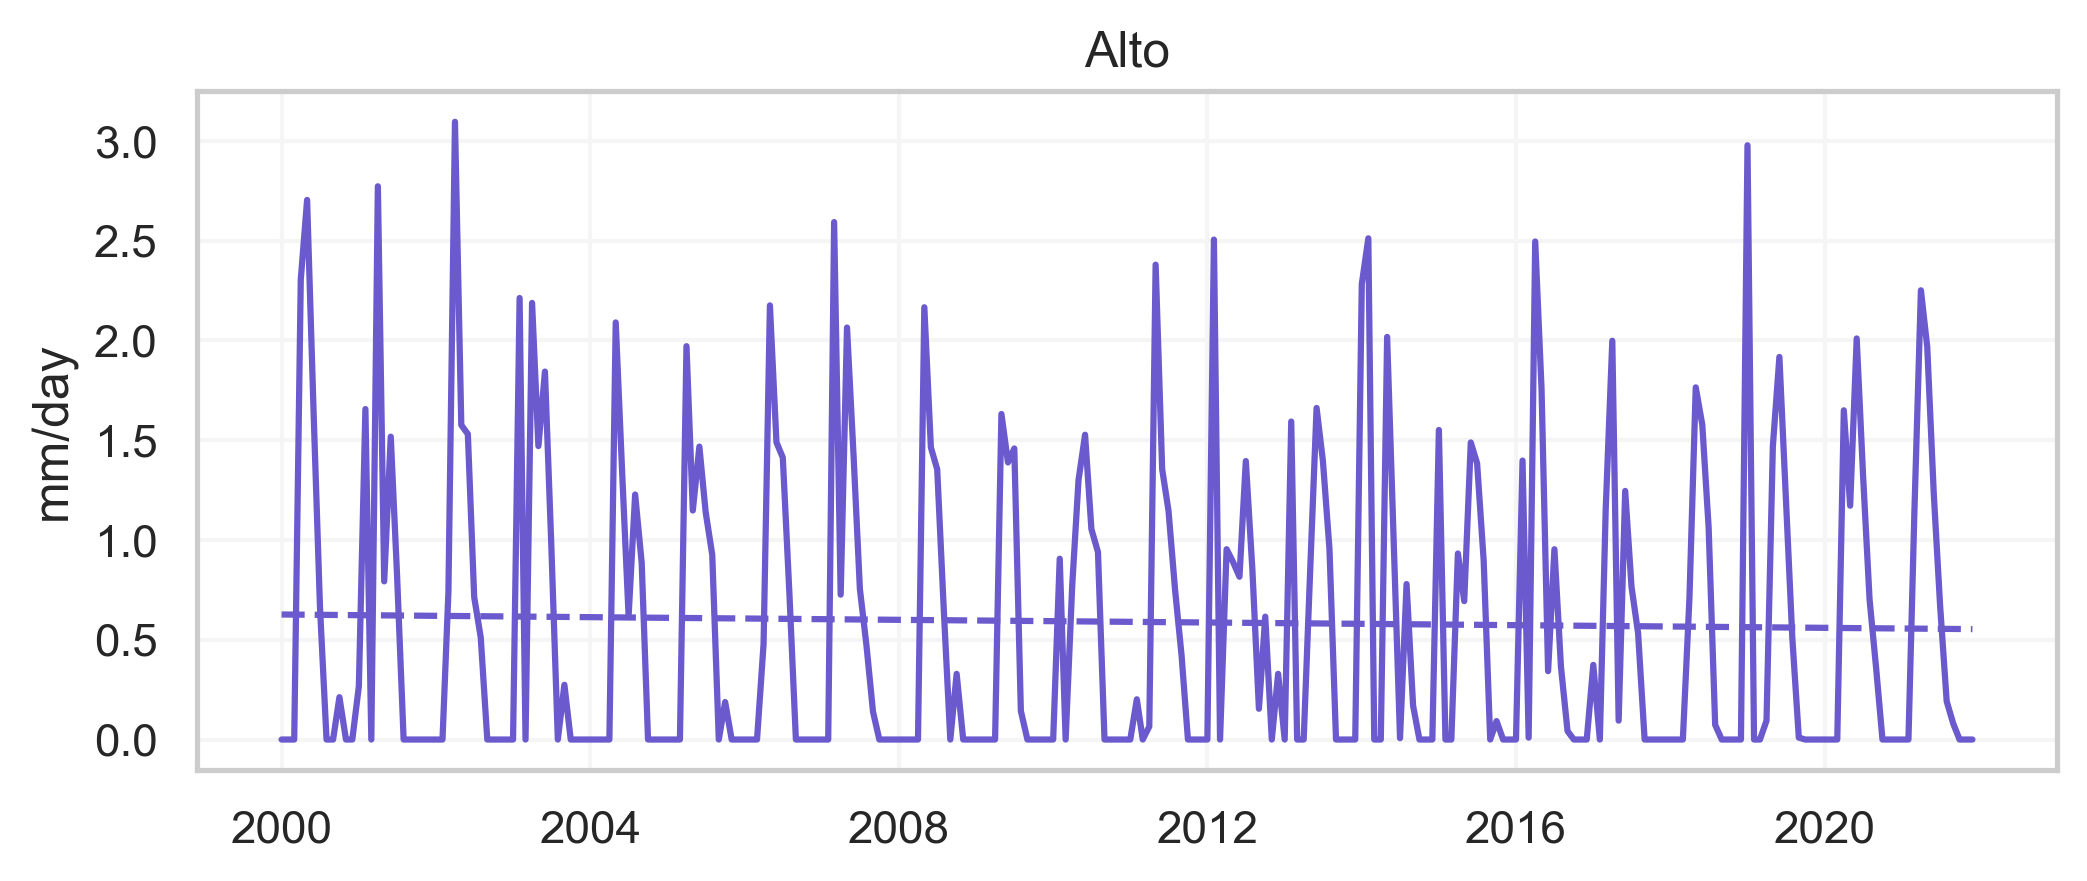

In [233]:
f, ax = plt.subplots(figsize=[8,3],dpi=300)

plt.grid('both', color='whitesmoke')
ax.plot(irrig_alt.time,irrig_alt.depth, color="slateblue")


# trendline (linear fitting)
z = np.polyfit(irrig_alt.index, irrig_alt.depth, 1)
p = np.poly1d(z)
ax.plot(irrig_alt.time,p(irrig_alt.index),'--',color="slateblue")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

plt.title('Alto')
plt.ylabel('mm/day')
#plt.show()

plt.savefig('sf_irrig_alt_depth.png')

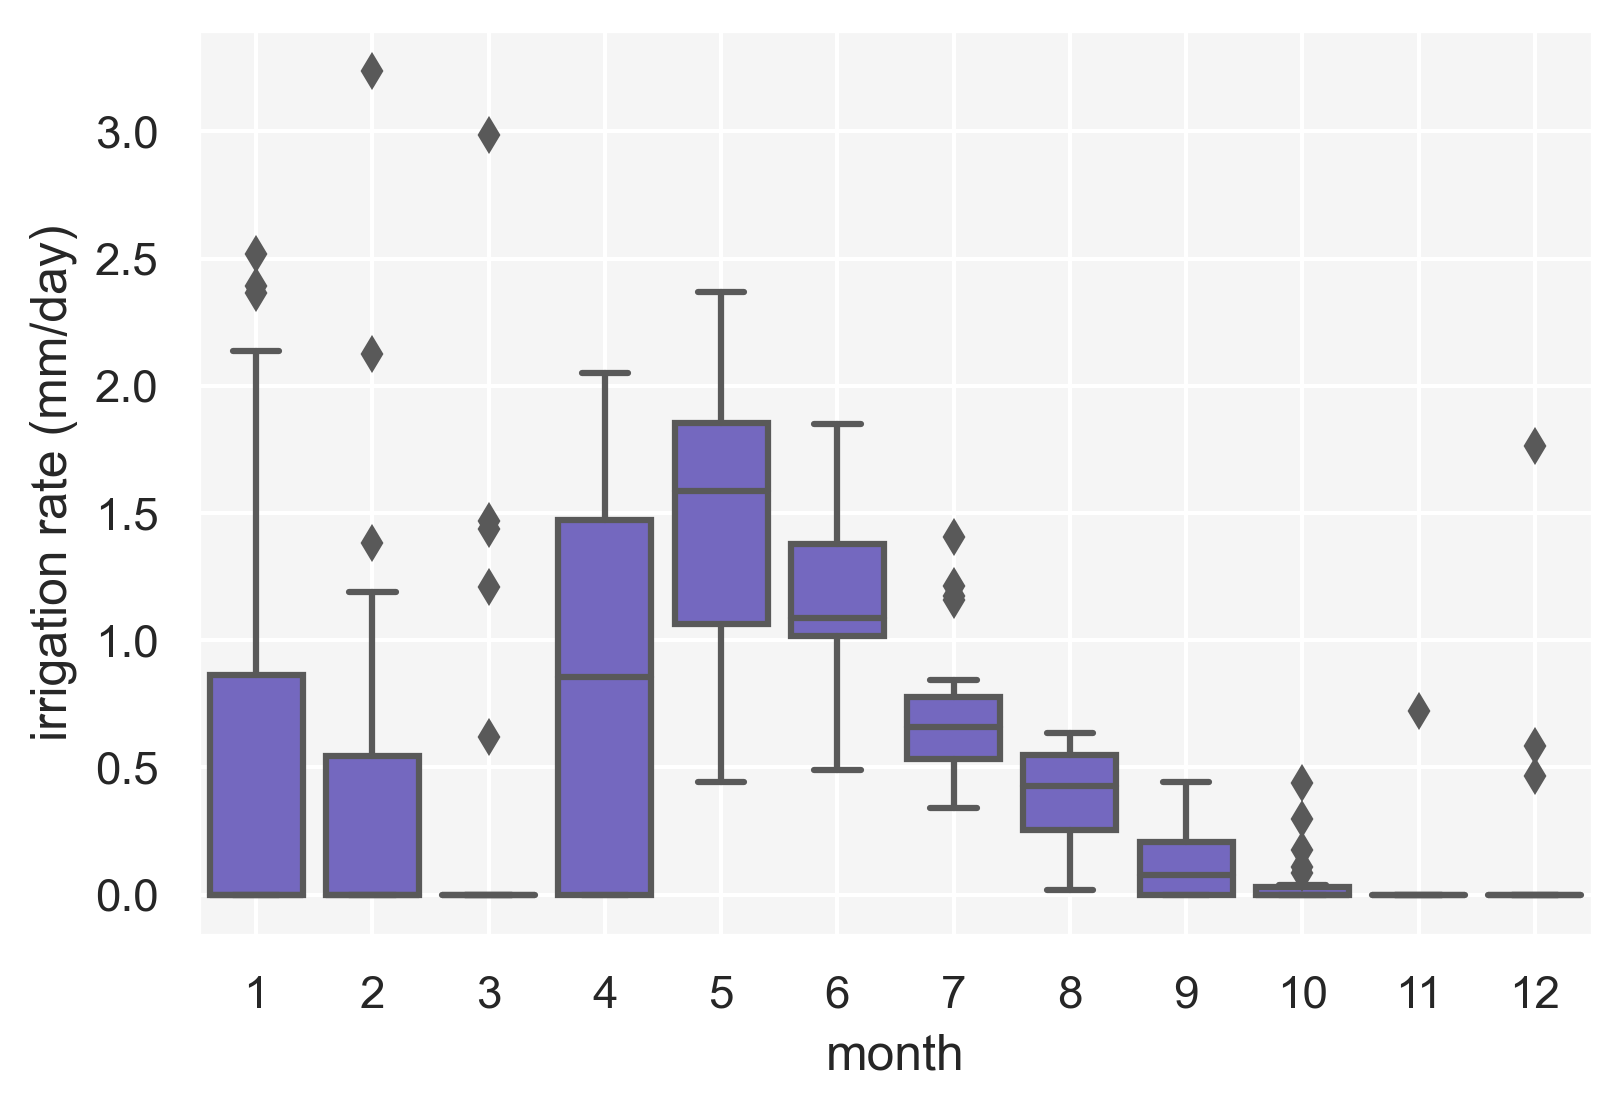

In [234]:
# Evapotranspiration boxplot
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300,'axes.facecolor':'whitesmoke'})
irrig['month'] = irrig.time.dt.month

ax = sns.boxplot(x="month", y="depth", data=irrig, color='slateblue')
ax.set_ylabel('irrigation rate (mm/day)')
ax.grid(True)

plt.savefig('sf_irrig_boxplot.png')

In [235]:
merged_irrig = pd.merge(left=irrig, right=pivo_sf, how='left', left_on='Ano', right_on='Ano')

# volume: average volume (m3/day) p/ month over the são francisco river basin
merged_irrig['volume'] = merged_irrig['depth']*merged_irrig['Pivô central']*10 
merged_irrig

# units expalined:
# depth = mm/day * 0.001 = m/day
# area of pivo central = Ha * 10,000 = m2
# combining both we get * 10 conversion factor

merged_irrig_bai = pd.merge(left=irrig_bai, right=pivo_bai, how='left', left_on='Ano', right_on='Ano')
merged_irrig_bai['volume'] = merged_irrig_bai['depth']*merged_irrig_bai['Pivô central']*10 

merged_irrig_sub = pd.merge(left=irrig_sub, right=pivo_sub, how='left', left_on='Ano', right_on='Ano')
merged_irrig_sub['volume'] = merged_irrig_sub['depth']*merged_irrig_sub['Pivô central']*10 

merged_irrig_med = pd.merge(left=irrig_med, right=pivo_med, how='left', left_on='Ano', right_on='Ano')
merged_irrig_med['volume'] = merged_irrig_med['depth']*merged_irrig_med['Pivô central']*10 

merged_irrig_alt = pd.merge(left=irrig_alt, right=pivo_alt, how='left', left_on='Ano', right_on='Ano')
merged_irrig_alt['volume'] = merged_irrig_alt['depth']*merged_irrig_alt['Pivô central']*10 


y=5986.343363x+(698388.051669)


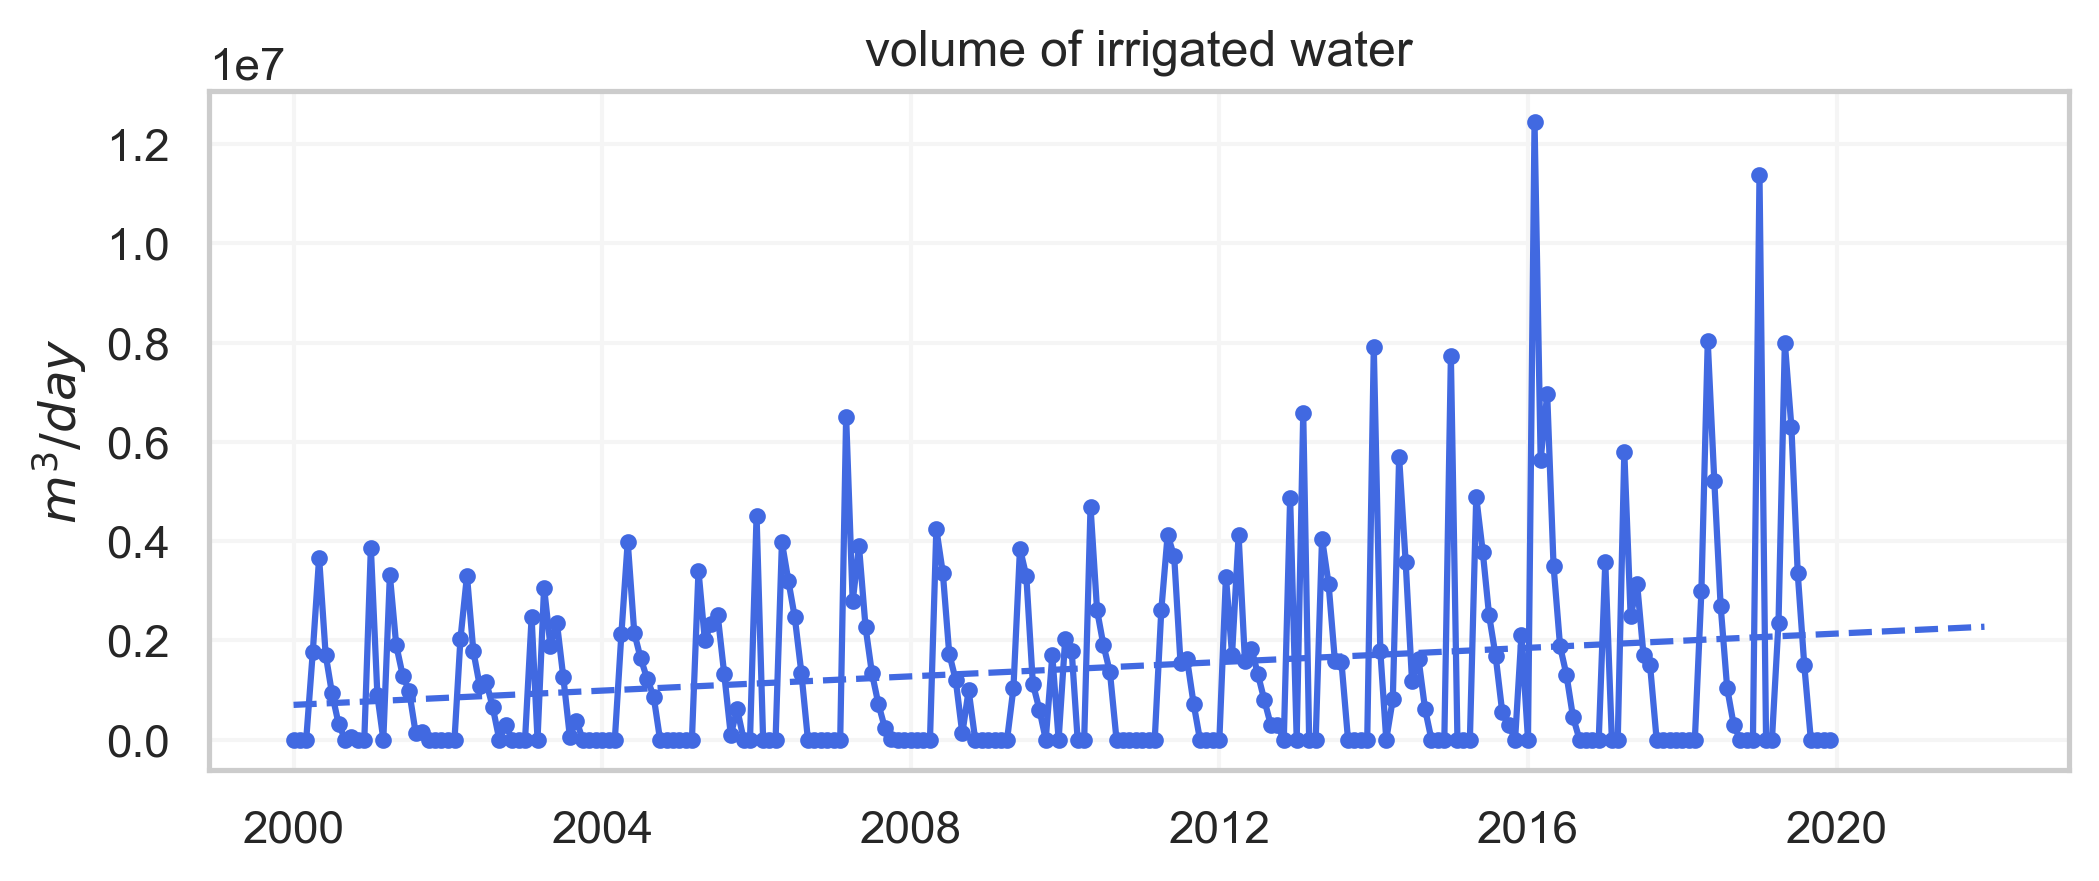

In [236]:
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=[8,3],dpi=300)

plt.grid('both', color='whitesmoke')
ax.plot(merged_irrig.time,merged_irrig.volume, color="royalblue", marker='.')

# trendline (linear fitting)
idx = np.isfinite(merged_irrig.index) & np.isfinite(merged_irrig.volume) # returns indexes that are not NaN
z = np.polyfit(merged_irrig.index[idx], merged_irrig.volume[idx], 1)
p = np.poly1d(z)
ax.plot(merged_irrig.time,p(merged_irrig.index),'--',color="royalblue")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

plt.title('volume of irrigated water')
plt.ylabel('$m^3/day$')
#plt.show()

plt.savefig('sf_irrig_vol.png')

y=2.200492x+(814.690633)


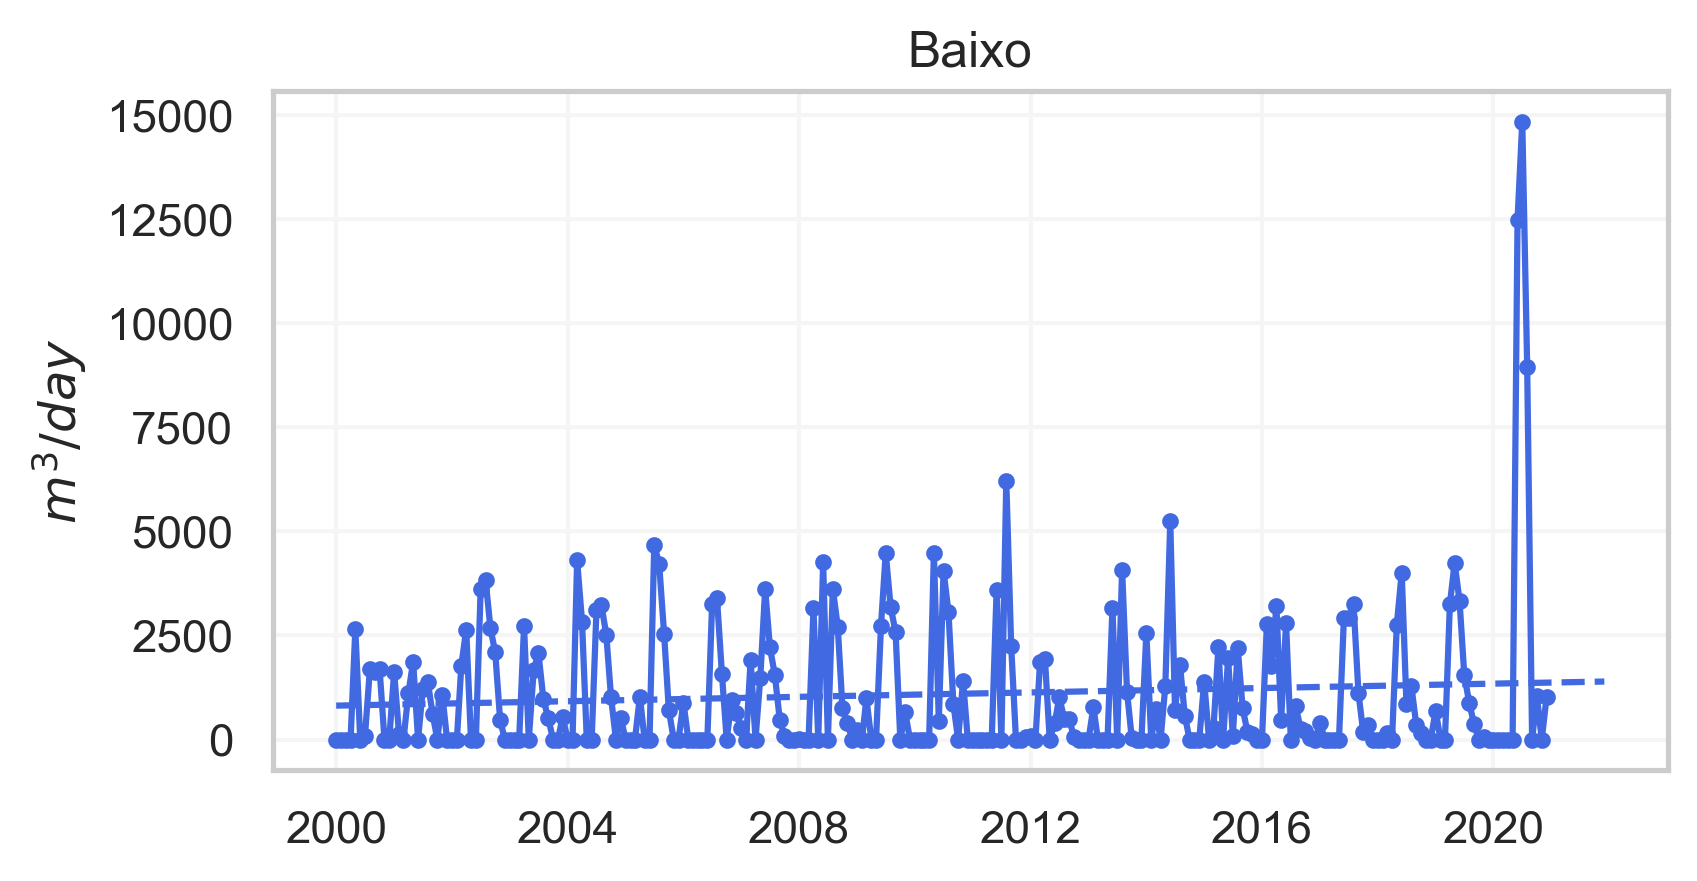

In [237]:
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=[6,3],dpi=300)

plt.grid('both', color='whitesmoke')
ax.plot(merged_irrig_bai.time,merged_irrig_bai.volume, color="royalblue", marker='.')

# trendline (linear fitting)
idx = np.isfinite(merged_irrig_bai.index) & np.isfinite(merged_irrig_bai.volume) # returns indexes that are not NaN
z = np.polyfit(merged_irrig_bai.index[idx], merged_irrig_bai.volume[idx], 1)
p = np.poly1d(z)
ax.plot(merged_irrig_bai.time,p(merged_irrig_bai.index),'--',color="royalblue")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

plt.title('Baixo')
plt.ylabel('$m^3/day$')
#plt.show()

plt.savefig('sf_irrig_bai_vol.png')

In [242]:
# initialize list of lists
data = [[1, 31], [2, 28], [3, 31], [4, 30], [5, 31], [6, 30],[7, 31], [8, 31],[9, 30], [10, 31],[11, 30], [12, 31]]
 
# Create DataFrame that assigns correct # of days to months
daymonth = pd.DataFrame(data, columns = ['month', 'day_count'])
 
# adds month day_count to irrigation dataframe
merged_irrig = pd.merge(left=merged_irrig, right=daymonth, how='left', left_on='month', right_on='month')

# computes volume_month: total volume of water pumped (m3) / month over the são francisco river basin
merged_irrig['volume_month'] = merged_irrig['volume']*merged_irrig['day_count']

In [248]:
merged_irrig_bai['month'] = irrig_bai.time.dt.month
merged_irrig_sub['month'] = irrig_sub.time.dt.month
merged_irrig_med['month'] = irrig_med.time.dt.month
merged_irrig_alt['month'] = irrig_alt.time.dt.month

In [249]:
# adds month day_count to irrig_baiation dataframe
merged_irrig_bai = pd.merge(left=merged_irrig_bai, right=daymonth, how='left', left_on='month', right_on='month')
merged_irrig_sub = pd.merge(left=merged_irrig_sub, right=daymonth, how='left', left_on='month', right_on='month')
merged_irrig_med = pd.merge(left=merged_irrig_med, right=daymonth, how='left', left_on='month', right_on='month')
merged_irrig_alt = pd.merge(left=merged_irrig_alt, right=daymonth, how='left', left_on='month', right_on='month')

# computes volume_month: total volume of water pumped (m3) / month over the são francisco river basin
merged_irrig_bai['volume_month'] = merged_irrig_bai['volume']*merged_irrig_bai['day_count']
merged_irrig_sub['volume_month'] = merged_irrig_sub['volume']*merged_irrig_sub['day_count']
merged_irrig_med['volume_month'] = merged_irrig_med['volume']*merged_irrig_med['day_count']
merged_irrig_alt['volume_month'] = merged_irrig_alt['volume']*merged_irrig_alt['day_count']

In [254]:
# total volume of water used for irrigation each year
irrig_vol =  merged_irrig.groupby('Ano')['volume_month'].sum() #unit: m3
irrig_vol = pd.DataFrame(irrig_vol)
#cut last two data points (!)
irrig_vol = irrig_vol.truncate(after=2019)

In [260]:
# total volume of water used for irrigation each year SUB-BASINS
irrig_vol_bai =  merged_irrig_bai.groupby('Ano')['volume_month'].sum() #unit: m3
irrig_vol_bai = pd.DataFrame(irrig_vol_bai)
irrig_vol_bai = irrig_vol_bai.truncate(after=2020)

irrig_vol_sub =  merged_irrig_sub.groupby('Ano')['volume_month'].sum() #unit: m3
irrig_vol_sub = pd.DataFrame(irrig_vol_sub)
irrig_vol_sub = irrig_vol_sub.truncate(after=2020)

irrig_vol_med =  merged_irrig_med.groupby('Ano')['volume_month'].sum() #unit: m3
irrig_vol_med = pd.DataFrame(irrig_vol_med)
irrig_vol_med = irrig_vol_med.truncate(after=2020)

irrig_vol_alt =  merged_irrig_alt.groupby('Ano')['volume_month'].sum() #unit: m3
irrig_vol_alt = pd.DataFrame(irrig_vol_alt)
irrig_vol_alt = irrig_vol_alt.truncate(after=2020)

In [244]:
from matplotlib.ticker import FormatStrFormatter

y=0.028291x+(-56.334458)
r = [[1.         0.81560628]
 [0.81560628 1.        ]]
r-squared = [[1.        0.6652136]
 [0.6652136 1.       ]]


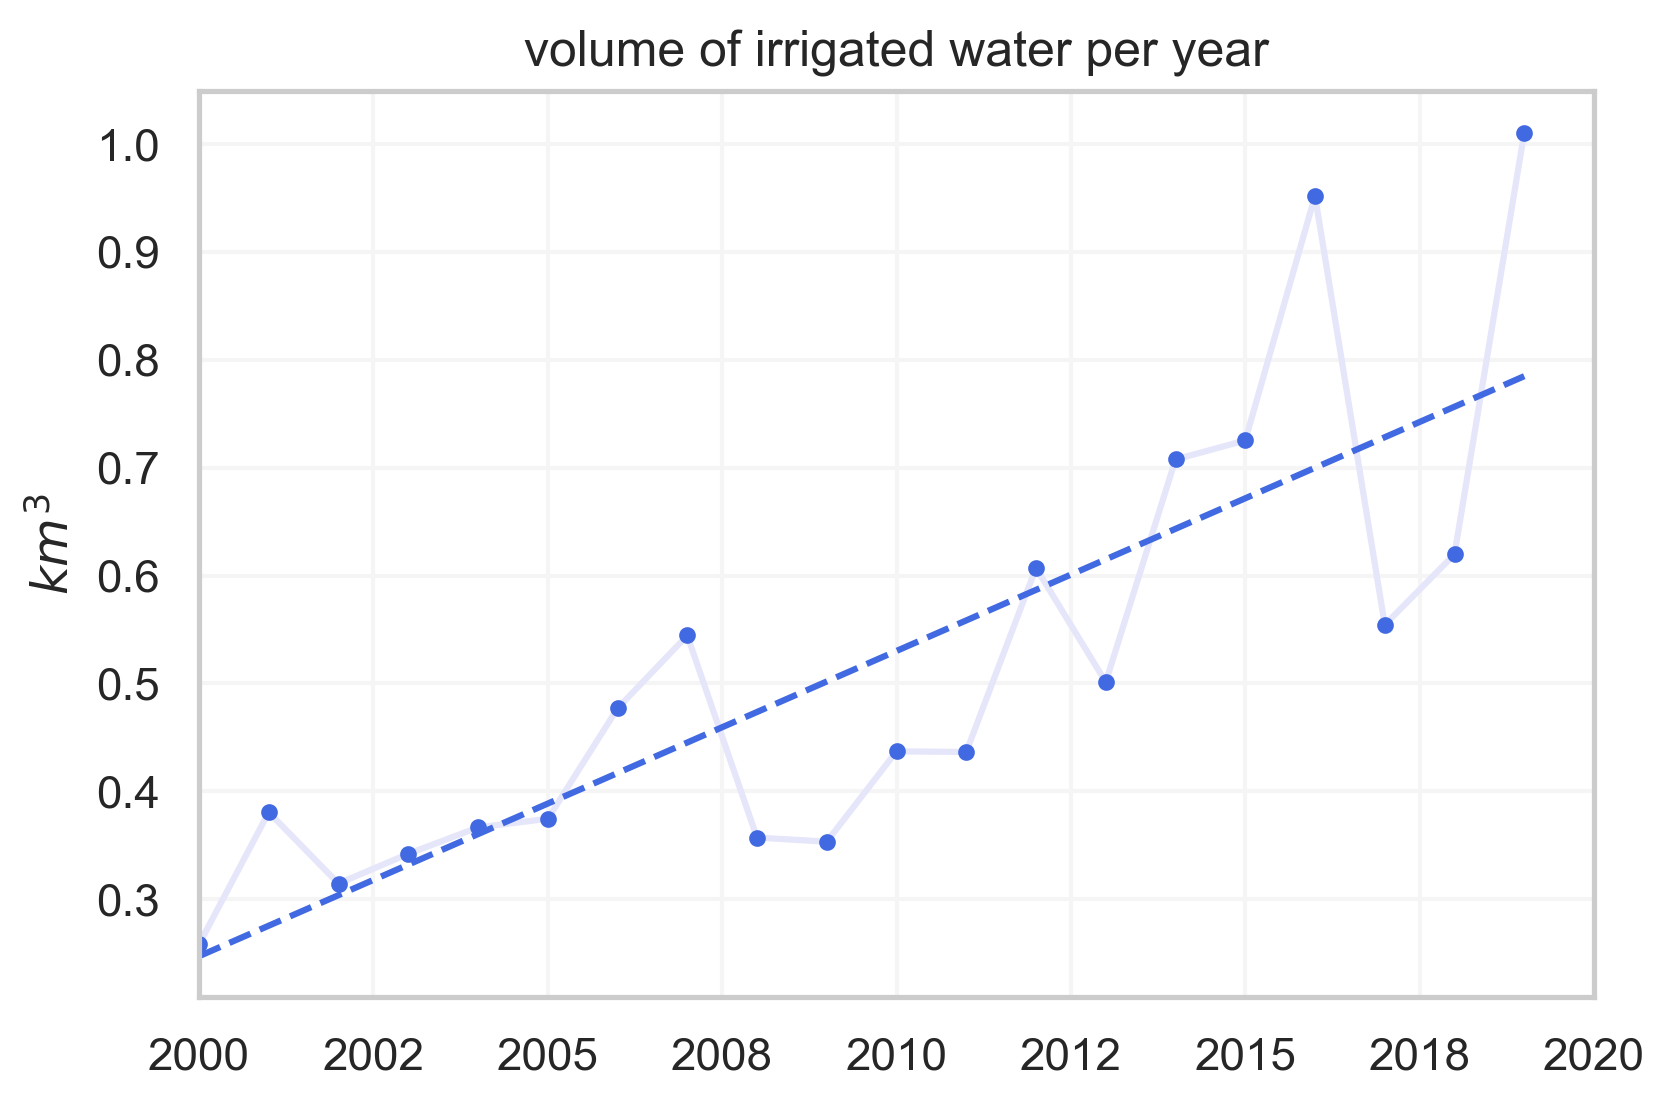

In [245]:
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=[6,4],dpi=300)

plt.grid('both', color='whitesmoke')
ax.plot(irrig_vol/10**9, color="lavender",marker='.', markerfacecolor='royalblue',markeredgecolor='royalblue')
# ax.scatter(irrig_vol.index,irrig_vol/10**9, color="royalblue", marker='.')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# trendline (linear fitting)
z = np.polyfit(irrig_vol.index, irrig_vol.volume_month/10**9, 1)
p = np.poly1d(z)
ax.plot(irrig_vol.index,p(irrig_vol.index),'--',color="royalblue")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

# Pearson's coefficient (R) and R^2
r = np.corrcoef(irrig_vol.index,irrig_vol.volume_month/10**9)
r2 = r**2
print("r =",r)
print("r-squared =",r2)

plt.title('volume of irrigated water per year')
plt.ylabel('$km^3$')
plt.xlim([2000, 2020])
#plt.show()

plt.savefig('sf_irrig_vol.png')

In [ ]:
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=[6,4],dpi=300)

plt.grid('both', color='whitesmoke')
ax.plot(irrig_vol/10**9, color="lavender",marker='.', markerfacecolor='royalblue',markeredgecolor='royalblue')
# ax.scatter(irrig_vol.index,irrig_vol/10**9, color="royalblue", marker='.')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# trendline (linear fitting)
z = np.polyfit(irrig_vol.index, irrig_vol.volume_month/10**9, 1)
p = np.poly1d(z)
ax.plot(irrig_vol.index,p(irrig_vol.index),'--',color="royalblue")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

# Pearson's coefficient (R) and R^2
r = np.corrcoef(irrig_vol.index,irrig_vol.volume_month/10**9)
r2 = r**2
print("r =",r)
print("r-squared =",r2)

plt.title('volume of irrigated water per year')
plt.ylabel('$km^3$')
plt.xlim([2000, 2020])
#plt.show()

plt.savefig('sf_irrig_vol.png')

y=-0.000118x+(0.240641)
r = [[ 1.        -0.5906097]
 [-0.5906097  1.       ]]
r-squared = [[1.         0.34881982]
 [0.34881982 1.        ]]


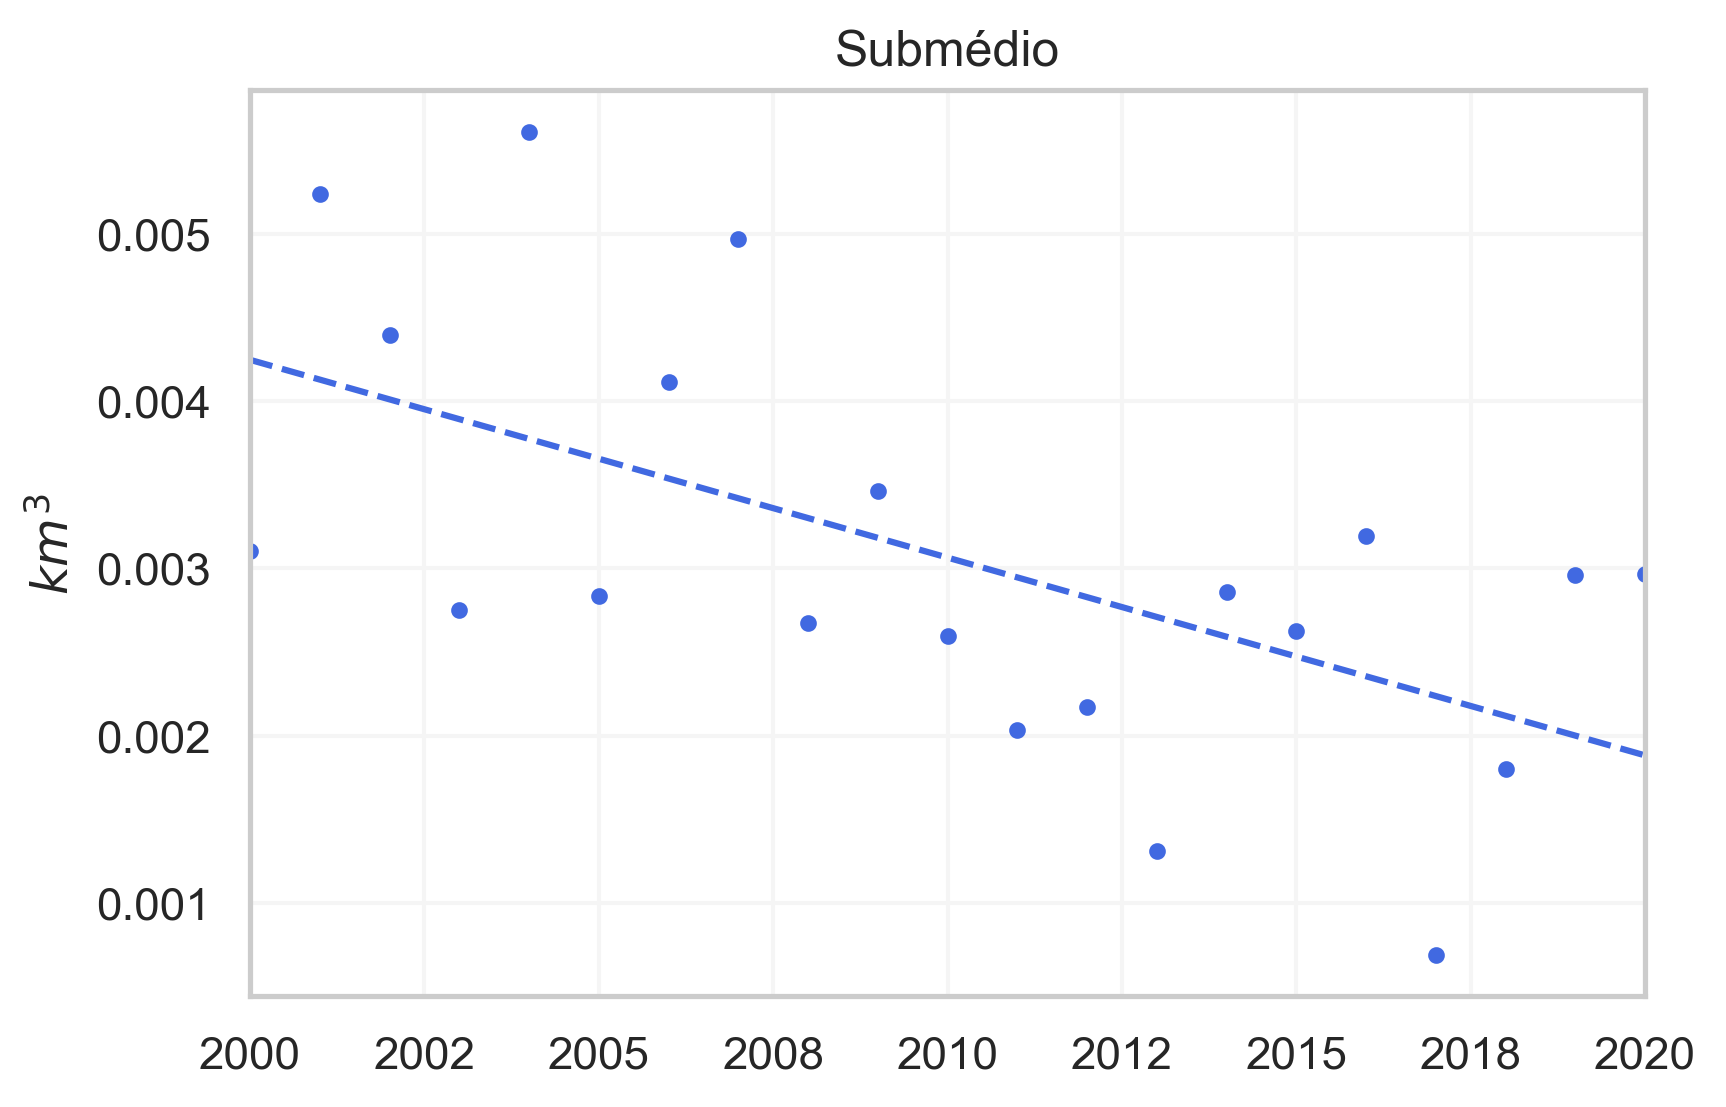

In [276]:
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=[6,4],dpi=300)

plt.grid('both', color='whitesmoke')
# ax.plot(irrig_vol_sub/10**9, color="lavender",marker='.', markerfacecolor='royalblue',markeredgecolor='royalblue')
ax.scatter(irrig_vol_sub.index,irrig_vol_sub/10**9, color="royalblue", marker='.')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# trendline (linear fitting)
z = np.polyfit(irrig_vol_sub.index, irrig_vol_sub.volume_month/10**9, 1)
p = np.poly1d(z)
ax.plot(irrig_vol_sub.index,p(irrig_vol_sub.index),'--',color="royalblue")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

# Pearson's coefficient (R) and R^2
r = np.corrcoef(irrig_vol_sub.index,irrig_vol_sub.volume_month/10**9)
r2 = r**2
print("r =",r)
print("r-squared =",r2)

plt.title('Submédio')
plt.ylabel('$km^3$')
plt.xlim([2000, 2020])
#plt.show()

plt.savefig('sf_irrig_vol_sub.png',bbox_inches='tight')

In [197]:
# calculating
# 2808 m3/s might be avg flow of sao francisco river
# * seconds in a year * conversion to km3
print(1.0/(365 *3.154e+7*10**-9) * 100, '% of flow used for irrigation')

365 *3.154e+7*10**-9

8.686512452115599 % of flow used for irrigation


11.5121